# Import and Install Library

In [1]:
# Cleanup to ensure no residual files remain

!pip uninstall -y transformers accelerate peft bitsandbytes sentence-transformers
!rm -rf /usr/local/lib/python3.11/dist-packages/transformers*
!rm -rf /usr/local/lib/python3.11/dist-packages/peft*
!rm -rf /usr/local/lib/python3.11/dist-packages/accelerate*
!rm -rf /usr/local/lib/python3.11/dist-packages/bitsandbytes*

Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: accelerate 1.9.0
Uninstalling accelerate-1.9.0:
  Successfully uninstalled accelerate-1.9.0
Found existing installation: peft 0.16.0
Uninstalling peft-0.16.0:
  Successfully uninstalled peft-0.16.0
Found existing installation: sentence-transformers 4.1.0
Uninstalling sentence-transformers-4.1.0:
  Successfully uninstalled sentence-transformers-4.1.0


In [4]:
# Install The Library

!pip install -q \
    "transformers==4.38.2" \
    "peft==0.9.0" \
    "accelerate==0.28.0" \
    "scikit-learn==1.3.2" \
    "datasets==2.18.0" \
    "evaluate" \
    "matplotlib" \
    "seaborn" \
    "sentence-transformers"

In [5]:
# Import Library

import os
import gc
import time
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import transformers
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments,
    Trainer, BitsAndBytesConfig, set_seed, EarlyStoppingCallback
)
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset, DatasetDict
import evaluate

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA tidak tersedia")

GPU: Tesla T4


# Function & Configuration

In [6]:
# Configuration
class BaseConfig:
    TARGET_COLUMN = 'Emotion'
    DATASETS = ["raw", "norm"] 
    SEEDS = [42, 2023, 7]
    MAX_LENGTH = 64
    BATCH_SIZE = 16
    EPOCHS = 4
    OUTPUT_DIR = "/kaggle/working/models"

CONFIG = BaseConfig()

In [7]:
# Load Data Function
def load_presplit_data(dataset_type, label_column):
    """
    Load pre-split train/val/test from new folder structure
    No splitting needed - data already divided
    
    Args:
        dataset_type: "raw" or "norm"
        label_column: name of label column (e.g., "Emotion")
    
    Returns:
        train_df, val_df, test_df, id2label, label2id, text_column
    """
    BASE_PATH = "/kaggle/input/split-raw-norm"
    
    DATASET_CONFIGS = {
        "raw": {
            "train": f"{BASE_PATH}/split/raw/train_raw.csv",
            "val": f"{BASE_PATH}/split/raw/val_raw.csv",
            "test": f"{BASE_PATH}/split/raw/test_raw.csv",
            "text_column": "text"
        },
        "norm": {
            "train": f"{BASE_PATH}/split/norm/train_norm.csv",
            "val": f"{BASE_PATH}/split/norm/val_norm.csv",
            "test": f"{BASE_PATH}/split/norm/test_norm.csv",
            "text_column": "text"
        }
    }
    
    config = DATASET_CONFIGS[dataset_type]
    text_column = config["text_column"]
    
    print(f"\nData: {dataset_type}")
    train_df = pd.read_csv(config["train"])
    val_df = pd.read_csv(config["val"])
    test_df = pd.read_csv(config["test"])
    
    # Clean missing values
    train_df.dropna(subset=[text_column, label_column], inplace=True)
    val_df.dropna(subset=[text_column, label_column], inplace=True)
    test_df.dropna(subset=[text_column, label_column], inplace=True)
    
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    # Create label mappings from training set
    labels = sorted(train_df[label_column].unique().tolist())
    label2id = {label: i for i, label in enumerate(labels)}
    id2label = {i: label for i, label in enumerate(labels)}
    
    # Map labels
    train_df['labels'] = train_df[label_column].map(label2id)
    val_df['labels'] = val_df[label_column].map(label2id)
    test_df['labels'] = test_df[label_column].map(label2id)
    
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    
    return train_df, val_df, test_df, id2label, label2id, text_column

In [8]:
# Convertion to Hugging Face Dataset Function
def convert_to_hf_dataset(train_df, val_df, test_df):
    return DatasetDict({
        'train': Dataset.from_pandas(train_df),
        'validation': Dataset.from_pandas(val_df),
        'test': Dataset.from_pandas(test_df)
    })

In [9]:
# Training & Evaluation Transformer (FT, LoRA, QLoRA) Function
def train_and_evaluate_transformer(dataset, text_col, model_name, peft_method, id2label, label2id, seed):
    print(f"\n----- Training: {model_name} | Method: {peft_method} | Seed: {seed} -----")
    set_seed(seed)
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token

    def tokenize_function(examples):
        return tokenizer(examples[text_col], padding="max_length", truncation=True, max_length=CONFIG.MAX_LENGTH)
    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    bnb_config = None
    if peft_method == "qlora":
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
        )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(id2label), id2label=id2label, label2id=label2id,
        quantization_config=bnb_config, device_map="auto" if peft_method == "qlora" else None
    )
    if peft_method != "qlora": model.to("cuda")
    model.config.pad_token_id = tokenizer.pad_token_id

    if peft_method in ["lora", "qlora"]:
        lora_config = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.1, bias="none", task_type=TaskType.SEQ_CLS)
        model = get_peft_model(model, lora_config)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable_params:,} || Total params: {total_params:,} || Trainable %: {100 * trainable_params / total_params:.4f}")

    lr = 2e-5 if peft_method == "full_ft" else 1e-4
    output_path = os.path.join(CONFIG.OUTPUT_DIR, f"{model_name.split('/')[-1]}-{peft_method}-{seed}")
    
    def compute_metrics_trainer(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {"accuracy": accuracy_score(labels, predictions), "f1-macro": f1_score(labels, predictions, average="macro")}

    training_args = TrainingArguments(
        output_dir=output_path, num_train_epochs=CONFIG.EPOCHS,
        per_device_train_batch_size=CONFIG.BATCH_SIZE, per_device_eval_batch_size=CONFIG.BATCH_SIZE,
        learning_rate=lr, weight_decay=0.01, evaluation_strategy="epoch", save_strategy="epoch",
        load_best_model_at_end=True, metric_for_best_model="f1-macro", greater_is_better=True,
        fp16=True, report_to="none"
    )
    trainer = Trainer(
        model=model, args=training_args, train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"], tokenizer=tokenizer, compute_metrics=compute_metrics_trainer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    
    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()
    trainer.train()
    total_train_time = time.time() - start_time
    peak_gpu_memory_mb = torch.cuda.max_memory_allocated() / (1024**2)

    print("\n--- Test Set Evaluation ---")
    test_predictions = trainer.predict(tokenized_datasets["test"])
    y_true = test_predictions.label_ids
    y_pred = np.argmax(test_predictions.predictions, axis=-1)
    
    print("\nClassification Report:")
    class_names = list(label2id.keys())
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(f'Confusion Matrix - {peft_method}'); plt.show()

    adapter_size_mb = 0
    if peft_method in ["lora", "qlora"]:
        adapter_path = os.path.join(output_path, "final_adapter")
        model.save_pretrained(adapter_path)
        adapter_size_mb = sum(os.path.getsize(os.path.join(adapter_path, f)) for f in os.listdir(adapter_path)) / (1024**2)

    final_results = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1-macro": f1_score(y_true, y_pred, average="macro"),
        "precision-macro": precision_score(y_true, y_pred, average="macro"),
        "recall-macro": recall_score(y_true, y_pred, average="macro"),
        "total_train_time": total_train_time, "peak_gpu_memory_mb": peak_gpu_memory_mb,
        "num_trainable_params": trainable_params, "adapter_size_mb": adapter_size_mb
    }
    
    del model, trainer; gc.collect(); torch.cuda.empty_cache()
    return final_results

# A. TF-IDF + Logistic Regression

In [10]:
def train_and_evaluate_baseline(train_df, test_df, text_col, label_col_str, id2label, seed):
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.pipeline import Pipeline
      
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=seed, max_iter=1000, solver='liblinear'))
    ])
    
    start_time = time.time()
    pipeline.fit(train_df[text_col], train_df[label_col_str])
    total_train_time = time.time() - start_time
    
    y_true = test_df[label_col_str]
    y_pred = pipeline.predict(test_df[text_col])
    
    print("\nClassification Report - TF-IDF + Logistic Regression")
    class_names = list(id2label.values())
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - TF-IDF + Logistic Regression'); plt.show()
    
    results = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1-macro": f1_score(y_true, y_pred, average='macro'),
        "precision-macro": precision_score(y_true, y_pred, average='macro'),
        "recall-macro": recall_score(y_true, y_pred, average='macro'),
        "total_train_time": total_train_time,
        "peak_gpu_memory_mb": 0,
        "num_trainable_params": pipeline.named_steps['clf'].coef_.size,
        "adapter_size_mb": 0
    }
    return results


Data: raw
Train: 4320, Val: 540, Test: 540

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.58      0.28      0.38        68
        Fear       0.52      0.52      0.52        95
       Happy       0.73      0.90      0.81       174
        Love       0.73      0.49      0.59        84
     Sadness       0.55      0.65      0.59       119

    accuracy                           0.64       540
   macro avg       0.62      0.57      0.58       540
weighted avg       0.63      0.64      0.62       540



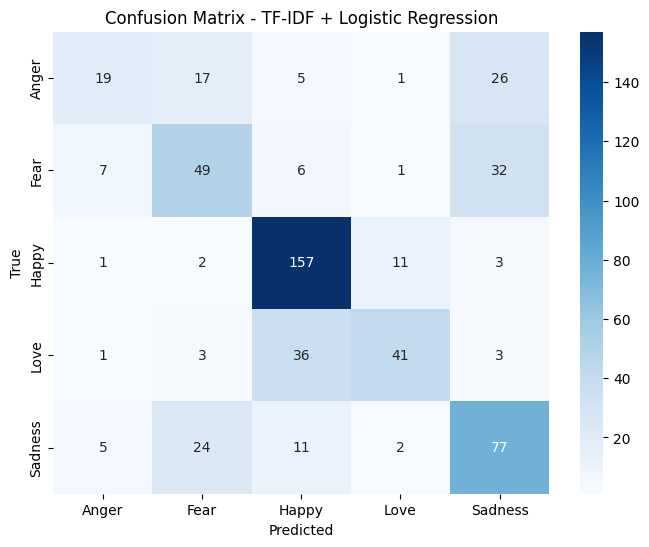


Data: raw
Train: 4320, Val: 540, Test: 540

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.58      0.28      0.38        68
        Fear       0.52      0.52      0.52        95
       Happy       0.73      0.90      0.81       174
        Love       0.73      0.49      0.59        84
     Sadness       0.55      0.65      0.59       119

    accuracy                           0.64       540
   macro avg       0.62      0.57      0.58       540
weighted avg       0.63      0.64      0.62       540



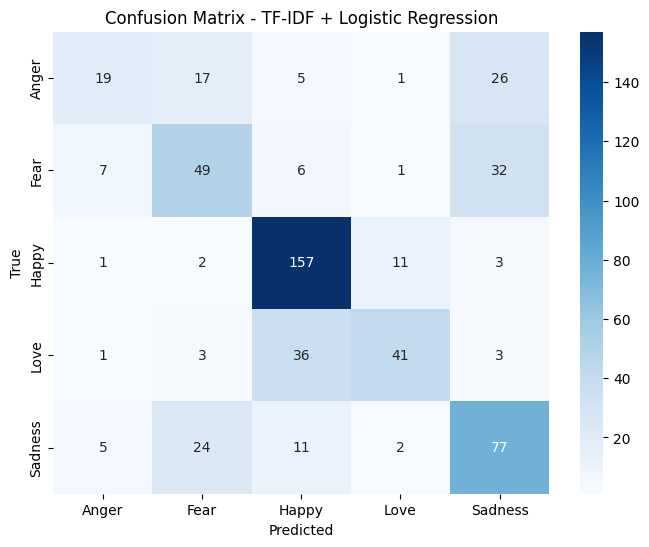


Data: raw
Train: 4320, Val: 540, Test: 540

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.58      0.28      0.38        68
        Fear       0.52      0.52      0.52        95
       Happy       0.73      0.90      0.81       174
        Love       0.73      0.49      0.59        84
     Sadness       0.55      0.65      0.59       119

    accuracy                           0.64       540
   macro avg       0.62      0.57      0.58       540
weighted avg       0.63      0.64      0.62       540



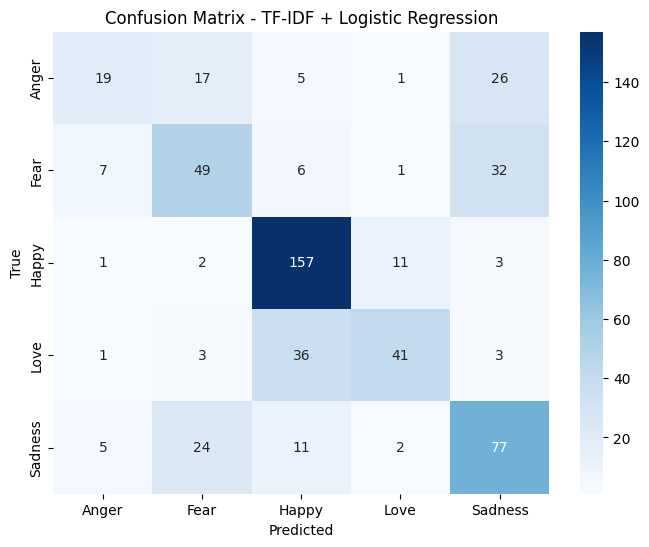


Data: norm
Train: 4314, Val: 539, Test: 540

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.53      0.32      0.40        60
        Fear       0.44      0.46      0.45        84
       Happy       0.69      0.90      0.78       174
        Love       0.73      0.44      0.55        84
     Sadness       0.65      0.66      0.66       138

    accuracy                           0.63       540
   macro avg       0.61      0.56      0.57       540
weighted avg       0.63      0.63      0.62       540



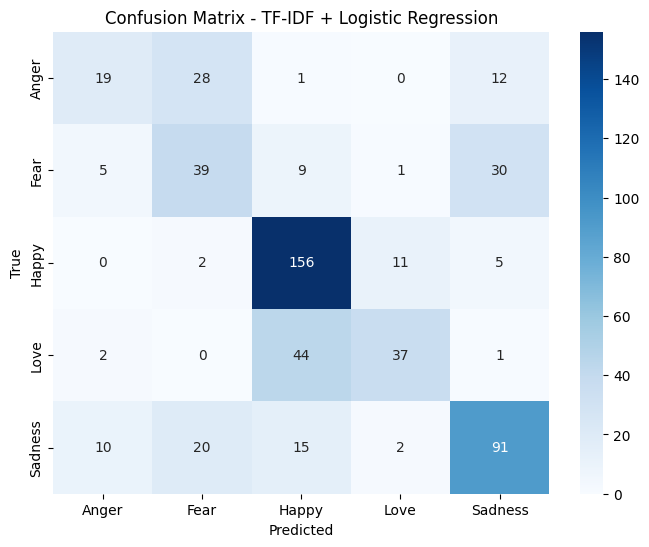


Data: norm
Train: 4314, Val: 539, Test: 540

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.53      0.32      0.40        60
        Fear       0.44      0.46      0.45        84
       Happy       0.69      0.90      0.78       174
        Love       0.73      0.44      0.55        84
     Sadness       0.65      0.66      0.66       138

    accuracy                           0.63       540
   macro avg       0.61      0.56      0.57       540
weighted avg       0.63      0.63      0.62       540



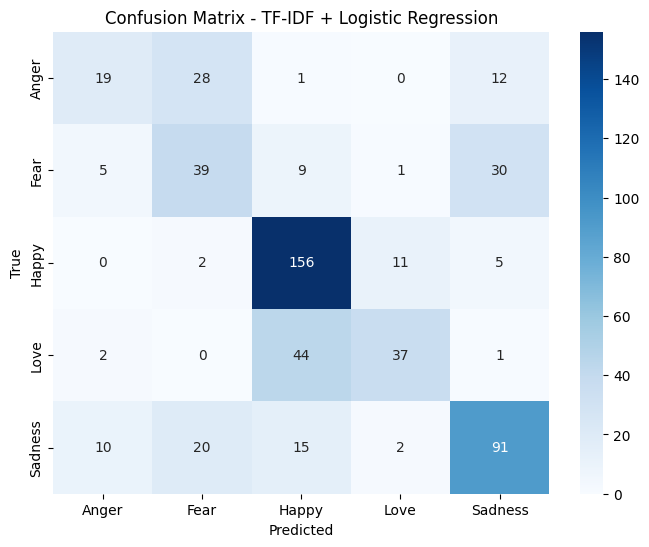


Data: norm
Train: 4314, Val: 539, Test: 540

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.53      0.32      0.40        60
        Fear       0.44      0.46      0.45        84
       Happy       0.69      0.90      0.78       174
        Love       0.73      0.44      0.55        84
     Sadness       0.65      0.66      0.66       138

    accuracy                           0.63       540
   macro avg       0.61      0.56      0.57       540
weighted avg       0.63      0.63      0.62       540



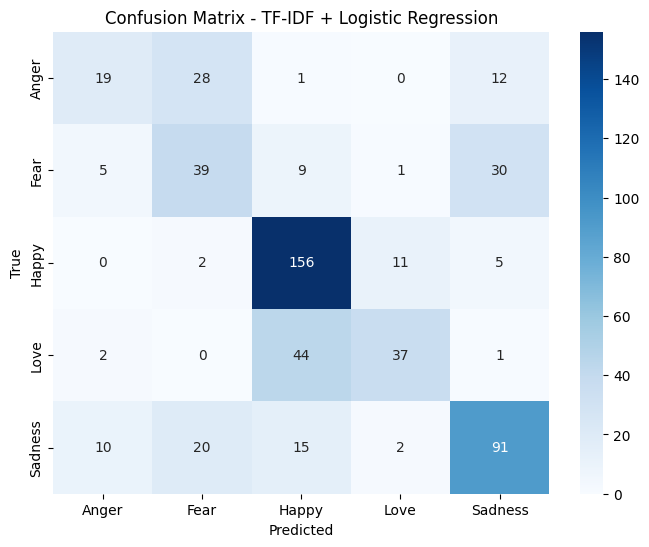

In [12]:
all_results_A = []

for dataset_name in CONFIG.DATASETS:
    for seed in CONFIG.SEEDS:
        try:
            # Load pre-split data
            train_df, val_df, test_df, id2label, label2id, text_col = load_presplit_data(
                dataset_name, CONFIG.TARGET_COLUMN
            )
            
            # Combine train + val for baseline (no validation needed)
            full_train_df = pd.concat([train_df, val_df])
            
            results = train_and_evaluate_baseline(
                full_train_df, test_df, text_col, CONFIG.TARGET_COLUMN, id2label, seed
            )
            
            run_info = {"dataset": dataset_name, "model": "TF-IDF + LogReg", "seed": seed}
            run_info.update(results)
            all_results_A.append(run_info)
        except Exception as e:
            print(f"!!! GAGAL: Dataset {dataset_name}, Seed {seed}. Error: {e}")
            continue

In [14]:
# Final Result for TF-IDF + Logistic Regression
if all_results_A:
    results_df_A = pd.DataFrame(all_results_A)
    print("Final Result for TF-IDF + Logistic Regression")
    display(results_df_A)

Final Result for TF-IDF + Logistic Regression


,dataset,model,seed,accuracy,f1-macro,precision-macro,recall-macro,total_train_time,peak_gpu_memory_mb,num_trainable_params,adapter_size_mb
0,raw,TF-IDF + LogReg,42,0.635185,0.575449,0.620004,0.566531,0.162115,0,42065,0
1,raw,TF-IDF + LogReg,2023,0.635185,0.575449,0.620004,0.566531,0.146538,0,42065,0
2,raw,TF-IDF + LogReg,7,0.635185,0.575449,0.620004,0.566531,0.144779,0,42065,0
3,norm,TF-IDF + LogReg,42,0.633333,0.566769,0.607896,0.555480,0.146075,0,42090,0
4,norm,TF-IDF + LogReg,2023,0.633333,0.566769,0.607896,0.555480,0.145076,0,42090,0
5,norm,TF-IDF + LogReg,7,0.633333,0.566769,0.607896,0.555480,0.139065,0,42090,0


# A2. Rapids GPU-Accelerated TF-IDF + Logistic Regression

In [15]:
# Install Rapids

!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12 cudf-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [16]:
def train_and_evaluate_baseline_gpu(train_df, test_df, text_col, label_col_str, id2label, seed):
    """
    GPU-accelerated version using Rapids cuML
    Falls back to CPU if Rapids not available
    """
    try:
        import cudf
        from cuml.linear_model import LogisticRegression as cuLogisticRegression
        from cuml.feature_extraction.text import TfidfVectorizer as cuTfidfVectorizer
        
        print("\n--- Training TF-IDF + Logistic Regression (GPU-Accelerated) ---")
        
        # Transfer to GPU
        train_gpu = cudf.DataFrame({
            'text': train_df[text_col].values,
            'label': train_df[label_col_str].values
        })
        test_gpu = cudf.DataFrame({
            'text': test_df[text_col].values,
            'label': test_df[label_col_str].values
        })
        
        # TF-IDF on GPU
        tfidf = cuTfidfVectorizer(max_features=5000)
        
        start_time = time.time()
        X_train = tfidf.fit_transform(train_gpu['text'])
        X_test = tfidf.transform(test_gpu['text'])
        
        # LogReg on GPU
        clf = cuLogisticRegression(max_iter=1000, solver='qn')
        clf.fit(X_train, train_gpu['label'])
        
        total_train_time = time.time() - start_time
        
        # Predict and transfer back to CPU
        y_pred_gpu = clf.predict(X_test)
        y_pred = y_pred_gpu.to_numpy() if hasattr(y_pred_gpu, 'to_numpy') else y_pred_gpu
        y_true = test_gpu['label'].to_numpy()
        
        # Estimate GPU memory (rough)
        import cupy as cp
        gpu_memory_mb = (cp.cuda.Device().mem_info[1] - cp.cuda.Device().mem_info[0]) / (1024**2)
        
        print(f"GPU Training Time: {total_train_time:.2f}s")
        
    except ImportError:
        print("Rapids not available, falling back to CPU version")
        return train_and_evaluate_baseline(train_df, test_df, text_col, label_col_str, id2label, seed)
    
    except Exception as e:
        print(f"GPU version failed ({e}), falling back to CPU")
        return train_and_evaluate_baseline(train_df, test_df, text_col, label_col_str, id2label, seed)
    
    # Metrics (same as CPU version)
    print("\nClassification Report")
    class_names = list(id2label.values())
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - TF-IDF (GPU)'); plt.show()
    
    results = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1-macro": f1_score(y_true, y_pred, average='macro'),
        "precision-macro": precision_score(y_true, y_pred, average='macro'),
        "recall-macro": recall_score(y_true, y_pred, average='macro'),
        "total_train_time": total_train_time,
        "peak_gpu_memory_mb": gpu_memory_mb,
        "num_trainable_params": 5000 * len(id2label),  # TF-IDF features * classes
        "adapter_size_mb": 0
    }
    return results


Data: raw
Train: 4320, Val: 540, Test: 540

--- Training TF-IDF + Logistic Regression (GPU-Accelerated) ---
GPU version failed (cannot create an OBJECT array from memory buffer), falling back to CPU

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.58      0.28      0.38        68
        Fear       0.52      0.52      0.52        95
       Happy       0.73      0.90      0.81       174
        Love       0.73      0.49      0.59        84
     Sadness       0.55      0.65      0.59       119

    accuracy                           0.64       540
   macro avg       0.62      0.57      0.58       540
weighted avg       0.63      0.64      0.62       540



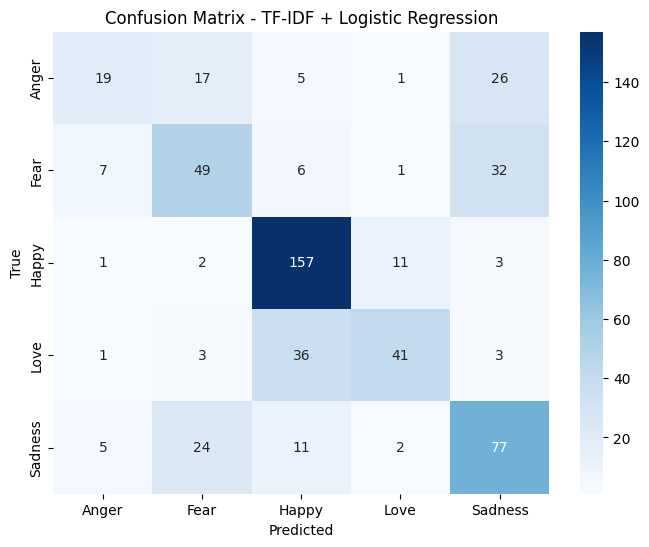


Data: raw
Train: 4320, Val: 540, Test: 540

--- Training TF-IDF + Logistic Regression (GPU-Accelerated) ---
GPU version failed (cannot create an OBJECT array from memory buffer), falling back to CPU

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.58      0.28      0.38        68
        Fear       0.52      0.52      0.52        95
       Happy       0.73      0.90      0.81       174
        Love       0.73      0.49      0.59        84
     Sadness       0.55      0.65      0.59       119

    accuracy                           0.64       540
   macro avg       0.62      0.57      0.58       540
weighted avg       0.63      0.64      0.62       540



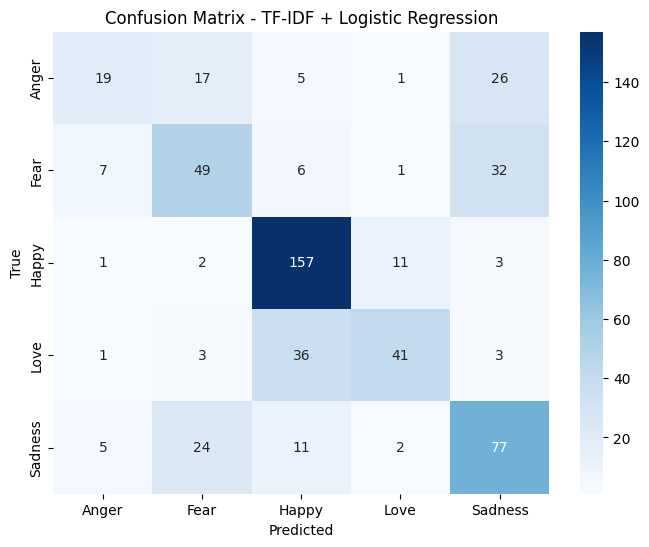


Data: raw
Train: 4320, Val: 540, Test: 540

--- Training TF-IDF + Logistic Regression (GPU-Accelerated) ---
GPU version failed (cannot create an OBJECT array from memory buffer), falling back to CPU

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.58      0.28      0.38        68
        Fear       0.52      0.52      0.52        95
       Happy       0.73      0.90      0.81       174
        Love       0.73      0.49      0.59        84
     Sadness       0.55      0.65      0.59       119

    accuracy                           0.64       540
   macro avg       0.62      0.57      0.58       540
weighted avg       0.63      0.64      0.62       540



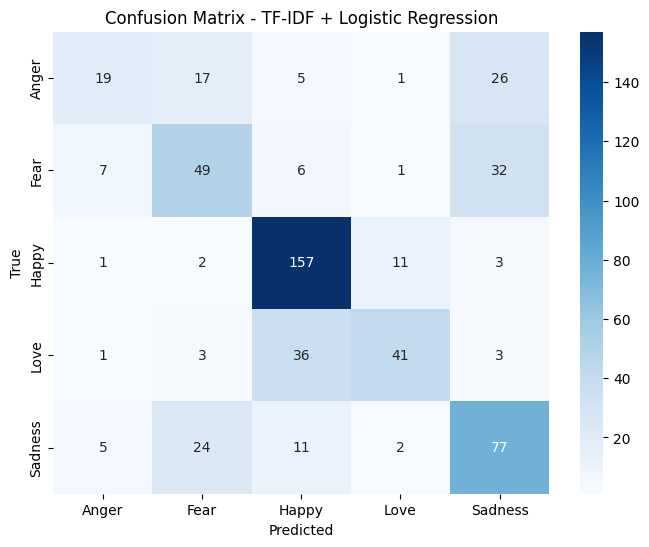


Data: norm
Train: 4314, Val: 539, Test: 540

--- Training TF-IDF + Logistic Regression (GPU-Accelerated) ---
GPU version failed (cannot create an OBJECT array from memory buffer), falling back to CPU

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.53      0.32      0.40        60
        Fear       0.44      0.46      0.45        84
       Happy       0.69      0.90      0.78       174
        Love       0.73      0.44      0.55        84
     Sadness       0.65      0.66      0.66       138

    accuracy                           0.63       540
   macro avg       0.61      0.56      0.57       540
weighted avg       0.63      0.63      0.62       540



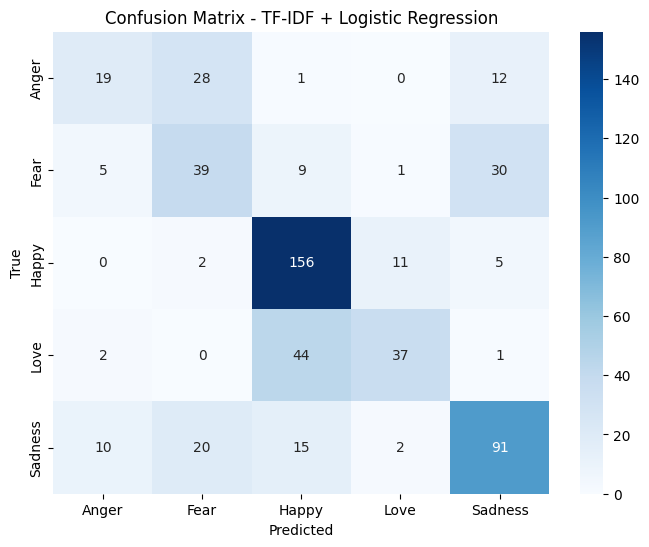


Data: norm
Train: 4314, Val: 539, Test: 540

--- Training TF-IDF + Logistic Regression (GPU-Accelerated) ---
GPU version failed (cannot create an OBJECT array from memory buffer), falling back to CPU

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.53      0.32      0.40        60
        Fear       0.44      0.46      0.45        84
       Happy       0.69      0.90      0.78       174
        Love       0.73      0.44      0.55        84
     Sadness       0.65      0.66      0.66       138

    accuracy                           0.63       540
   macro avg       0.61      0.56      0.57       540
weighted avg       0.63      0.63      0.62       540



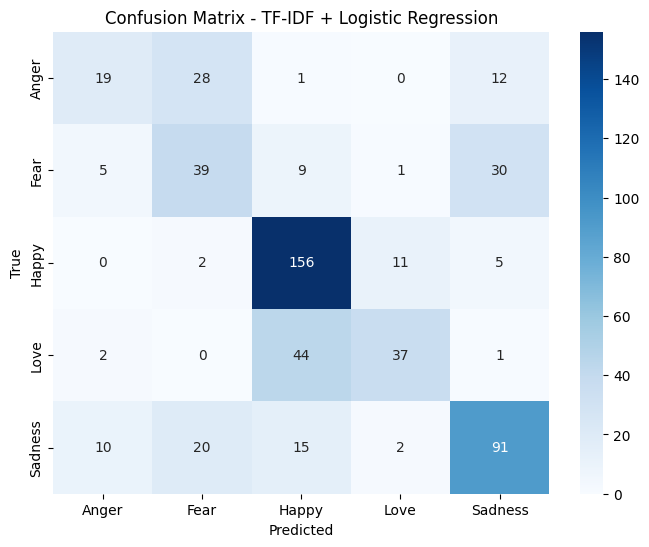


Data: norm
Train: 4314, Val: 539, Test: 540

--- Training TF-IDF + Logistic Regression (GPU-Accelerated) ---
GPU version failed (cannot create an OBJECT array from memory buffer), falling back to CPU

Classification Report - TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       Anger       0.53      0.32      0.40        60
        Fear       0.44      0.46      0.45        84
       Happy       0.69      0.90      0.78       174
        Love       0.73      0.44      0.55        84
     Sadness       0.65      0.66      0.66       138

    accuracy                           0.63       540
   macro avg       0.61      0.56      0.57       540
weighted avg       0.63      0.63      0.62       540



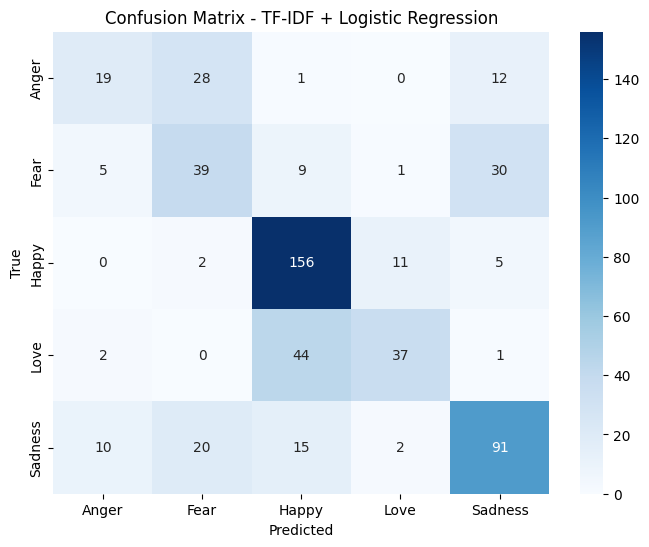

In [17]:
all_results_A2 = []

for dataset_name in CONFIG.DATASETS:
    for seed in CONFIG.SEEDS:
        try:
            train_df, val_df, test_df, id2label, label2id, text_col = load_presplit_data(
                dataset_name, CONFIG.TARGET_COLUMN
            )
            full_train_df = pd.concat([train_df, val_df])
            
            results = train_and_evaluate_baseline_gpu(
                full_train_df, test_df, text_col, CONFIG.TARGET_COLUMN, id2label, seed
            )
            
            run_info = {"dataset": dataset_name, "model": "TF-IDF + LogReg (GPU)", "seed": seed}
            run_info.update(results)
            all_results_A2.append(run_info)
        except Exception as e:
            print(f"!!! GAGAL: Dataset {dataset_name}, Seed {seed}. Error: {e}")
            continue

In [18]:
if all_results_A2:
    results_df_A2 = pd.DataFrame(all_results_A2)
    print("Final Result for TF-IDF + Logistic Regression (GPU Accelerated)")
    display(results_df_A2)

Final Result for TF-IDF + Logistic Regression (GPU Accelerated)


,dataset,model,seed,accuracy,f1-macro,precision-macro,recall-macro,total_train_time,peak_gpu_memory_mb,num_trainable_params,adapter_size_mb
0,raw,TF-IDF + LogReg (GPU),42,0.635185,0.575449,0.620004,0.566531,0.146948,0,42065,0
1,raw,TF-IDF + LogReg (GPU),2023,0.635185,0.575449,0.620004,0.566531,0.142030,0,42065,0
2,raw,TF-IDF + LogReg (GPU),7,0.635185,0.575449,0.620004,0.566531,0.143981,0,42065,0
3,norm,TF-IDF + LogReg (GPU),42,0.633333,0.566769,0.607896,0.555480,0.143048,0,42090,0
4,norm,TF-IDF + LogReg (GPU),2023,0.633333,0.566769,0.607896,0.555480,0.145396,0,42090,0
5,norm,TF-IDF + LogReg (GPU),7,0.633333,0.566769,0.607896,0.555480,0.145490,0,42090,0


# B. INDOBERTWEET + Full Fine Tuning

In [19]:
all_results_B = []
MODEL_NAME = "indolem/indobertweet-base-uncased"
PEFT_METHOD = "full_ft"


Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: full_ft | Seed: 42 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 110,562,053 || Total params: 110,562,053 || Trainable %: 100.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.736737,0.661111,0.588342
2,No log,0.709200,0.657407,0.622821
3,No log,0.658695,0.700000,0.654526
4,0.688900,0.666958,0.701852,0.661960


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.58      0.51      0.55        68
        Fear       0.54      0.54      0.54        95
       Happy       0.85      0.86      0.85       174
        Love       0.73      0.68      0.70        84
     Sadness       0.64      0.71      0.67       119

    accuracy                           0.70       540
   macro avg       0.67      0.66      0.66       540
weighted avg       0.70      0.70      0.70       540



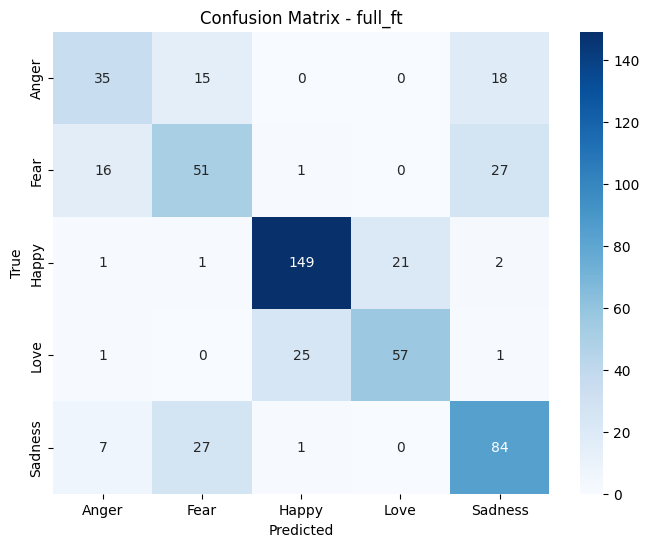


Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: full_ft | Seed: 2023 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 110,562,053 || Total params: 110,562,053 || Trainable %: 100.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.714377,0.653704,0.596909
2,No log,0.714496,0.674074,0.641011
3,No log,0.664127,0.701852,0.662313
4,0.673000,0.676085,0.703704,0.667670


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.58      0.56      0.57        68
        Fear       0.60      0.54      0.57        95
       Happy       0.85      0.84      0.85       174
        Love       0.72      0.71      0.72        84
     Sadness       0.67      0.76      0.71       119

    accuracy                           0.71       540
   macro avg       0.68      0.68      0.68       540
weighted avg       0.71      0.71      0.71       540



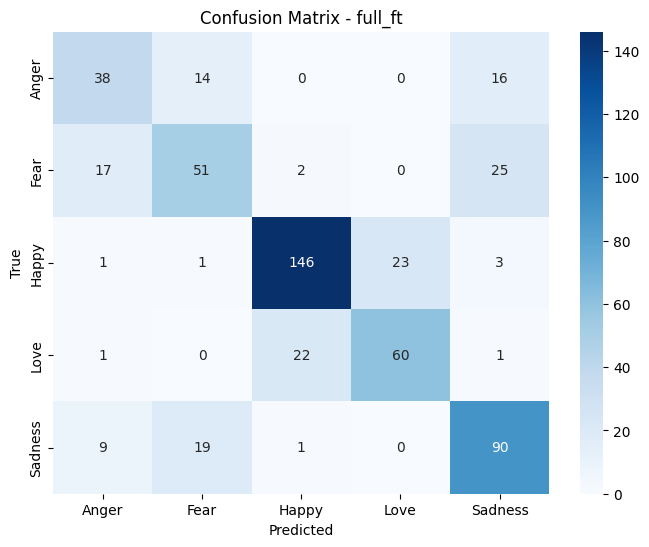


Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: full_ft | Seed: 7 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 110,562,053 || Total params: 110,562,053 || Trainable %: 100.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.716202,0.650000,0.585158
2,No log,0.699454,0.664815,0.633478
3,No log,0.653111,0.707407,0.664220
4,0.675200,0.664119,0.696296,0.653784


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.58      0.57      0.58        68
        Fear       0.56      0.53      0.54        95
       Happy       0.85      0.86      0.85       174
        Love       0.74      0.70      0.72        84
     Sadness       0.64      0.68      0.66       119

    accuracy                           0.70       540
   macro avg       0.67      0.67      0.67       540
weighted avg       0.70      0.70      0.70       540



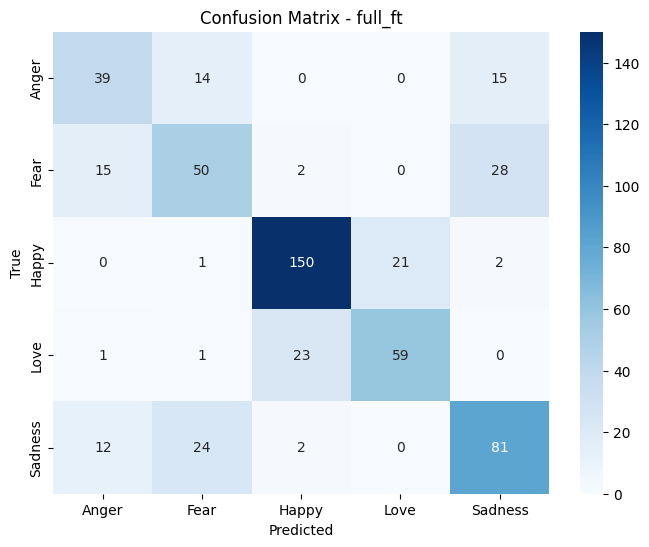


Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: full_ft | Seed: 42 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 110,562,053 || Total params: 110,562,053 || Trainable %: 100.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.744077,0.679035,0.620423
2,No log,0.652815,0.716141,0.689697
3,No log,0.663237,0.730983,0.705882
4,0.690800,0.654579,0.732839,0.712867


Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-full_ft-42/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-full_ft-42/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-full_ft-42/checkpoint-405 already exists and is non-empty. Saving will proceed


--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.59      0.53      0.56        60
        Fear       0.53      0.55      0.54        84
       Happy       0.81      0.86      0.83       174
        Love       0.71      0.65      0.68        84
     Sadness       0.68      0.69      0.68       138

    accuracy                           0.70       540
   macro avg       0.67      0.66      0.66       540
weighted avg       0.70      0.70      0.70       540



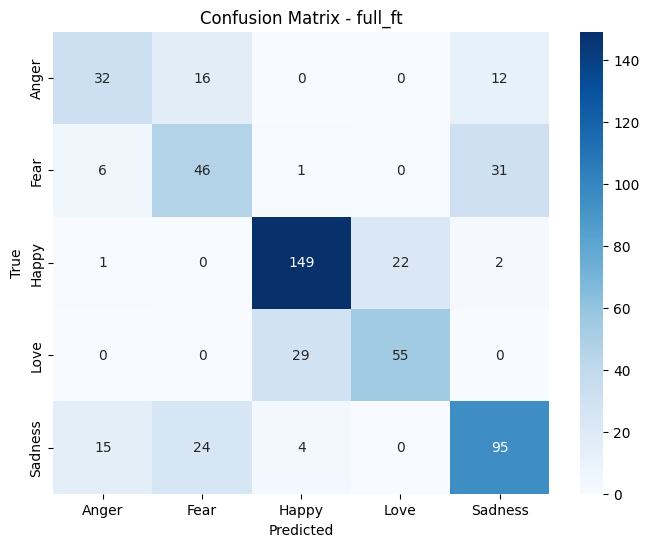


Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: full_ft | Seed: 2023 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 110,562,053 || Total params: 110,562,053 || Trainable %: 100.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.724457,0.680891,0.631427
2,No log,0.653320,0.716141,0.686037
3,No log,0.650944,0.721707,0.696125
4,0.676600,0.647038,0.730983,0.711314


Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-full_ft-2023/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-full_ft-2023/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-full_ft-2023/checkpoint-405 already exists and is non-empty. Saving will p


--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.61      0.58      0.60        60
        Fear       0.59      0.52      0.55        84
       Happy       0.84      0.86      0.85       174
        Love       0.72      0.70      0.71        84
     Sadness       0.69      0.74      0.72       138

    accuracy                           0.72       540
   macro avg       0.69      0.68      0.69       540
weighted avg       0.72      0.72      0.72       540



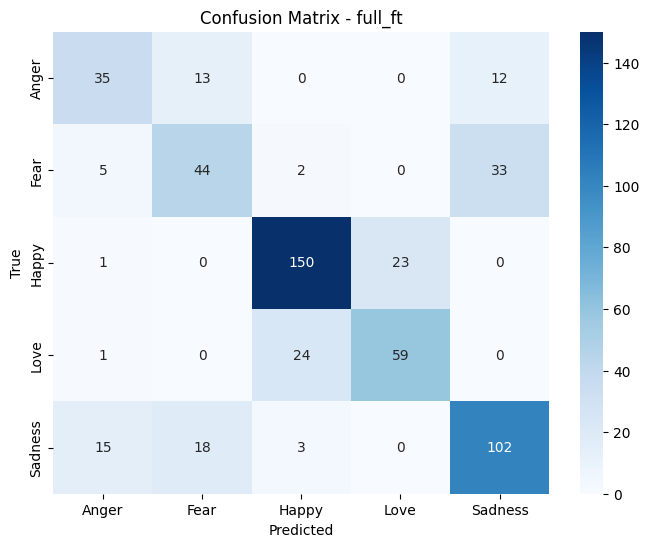


Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: full_ft | Seed: 7 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 110,562,053 || Total params: 110,562,053 || Trainable %: 100.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.721906,0.679035,0.634630
2,No log,0.646833,0.716141,0.688239
3,No log,0.645887,0.721707,0.695112
4,0.677400,0.647563,0.725417,0.702074


Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-full_ft-7/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-full_ft-7/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-full_ft-7/checkpoint-405 already exists and is non-empty. Saving will proceed bu


--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.55      0.55      0.55        60
        Fear       0.55      0.54      0.54        84
       Happy       0.84      0.86      0.85       174
        Love       0.72      0.69      0.70        84
     Sadness       0.68      0.68      0.68       138

    accuracy                           0.70       540
   macro avg       0.67      0.66      0.67       540
weighted avg       0.70      0.70      0.70       540



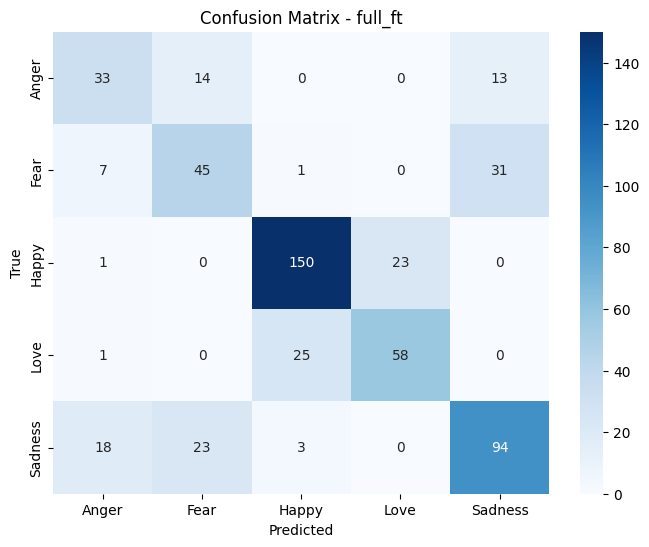

In [20]:
for dataset_name in CONFIG.DATASETS: 
    for seed in CONFIG.SEEDS:
        try:
            train_df, val_df, test_df, id2label, label2id, text_col = load_presplit_data( 
                dataset_name, CONFIG.TARGET_COLUMN  
            )
            hf_datasets = convert_to_hf_dataset(train_df, val_df, test_df)

            results = train_and_evaluate_transformer(
                hf_datasets, text_col, MODEL_NAME, PEFT_METHOD, id2label, label2id, seed
            )

            run_info = {"dataset": dataset_name, "model": "IndoBERTweet Full FT", "seed": seed}
            run_info.update(results)
            all_results_B.append(run_info)
        except Exception as e:
            print(f"!!! GAGAL: Dataset {dataset_name}, Seed {seed}. Error: {e}")
            continue

In [23]:
if all_results_B:
    results_df_B = pd.DataFrame(all_results_B)
    print("Final Result for INDOBERTWEET Full Fine Tuning")
    display(results_df_B)

Final Result for INDOBERTWEET Full Fine Tuning


,dataset,model,seed,accuracy,f1-macro,precision-macro,recall-macro,total_train_time,peak_gpu_memory_mb,num_trainable_params,adapter_size_mb
0,raw,IndoBERTweet Full FT,42,0.696296,0.662203,0.667922,0.658465,174.777088,2173.246094,110562053,0
1,raw,IndoBERTweet Full FT,2023,0.712963,0.681486,0.683823,0.681067,182.538060,2178.984375,110562053,0
2,raw,IndoBERTweet Full FT,7,0.701852,0.670751,0.673092,0.668993,183.675057,2178.234375,110562053,0
3,norm,IndoBERTweet Full FT,42,0.698148,0.660799,0.666908,0.656088,184.519881,2178.234375,110562053,0
4,norm,IndoBERTweet Full FT,2023,0.722222,0.685648,0.690416,0.682145,183.335371,2176.792969,110562053,0
5,norm,IndoBERTweet Full FT,7,0.703704,0.665243,0.666796,0.663884,184.164701,2178.984375,110562053,0


# C. INDOBERTWEET + LORA

In [24]:
all_results_C = []
MODEL_NAME = "indolem/indobertweet-base-uncased"
PEFT_METHOD = "lora"


Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: lora | Seed: 42 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 298,757 || Total params: 110,860,810 || Trainable %: 0.2695


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.162096,0.555556,0.335266
2,No log,0.891049,0.616667,0.466295
3,No log,0.835518,0.637037,0.504838
4,1.073100,0.825887,0.637037,0.502865


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 


--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       1.00      0.07      0.14        68
        Fear       0.50      0.27      0.35        95
       Happy       0.75      0.93      0.83       174
        Love       0.80      0.38      0.52        84
     Sadness       0.47      0.90      0.62       119

    accuracy                           0.61       540
   macro avg       0.70      0.51      0.49       540
weighted avg       0.68      0.61      0.56       540



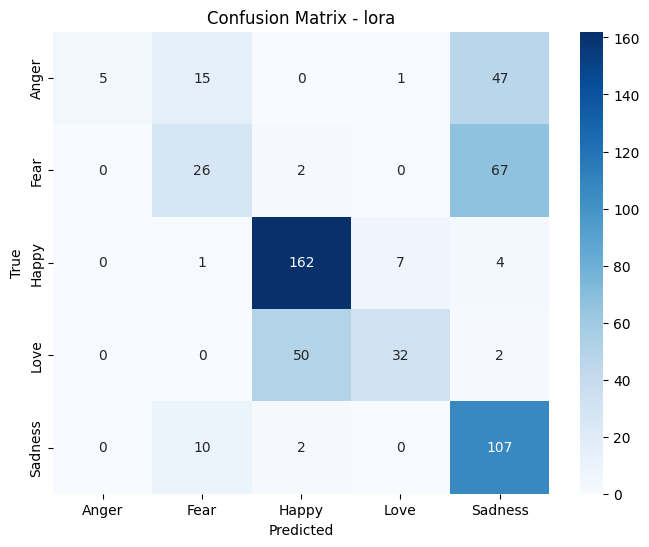

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: lora | Seed: 2023 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 298,757 || Total params: 110,860,810 || Trainable %: 0.2695


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.118266,0.562963,0.340096
2,No log,0.873556,0.614815,0.475373
3,No log,0.818875,0.637037,0.522045
4,1.049800,0.810466,0.638889,0.523991


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 


--- Test Set Evaluation ---



Classification Report:
              precision    recall  f1-score   support

       Anger       0.52      0.19      0.28        68
        Fear       0.50      0.17      0.25        95
       Happy       0.78      0.92      0.85       174
        Love       0.82      0.49      0.61        84
     Sadness       0.47      0.91      0.62       119

    accuracy                           0.63       540
   macro avg       0.62      0.53      0.52       540
weighted avg       0.64      0.63      0.58       540



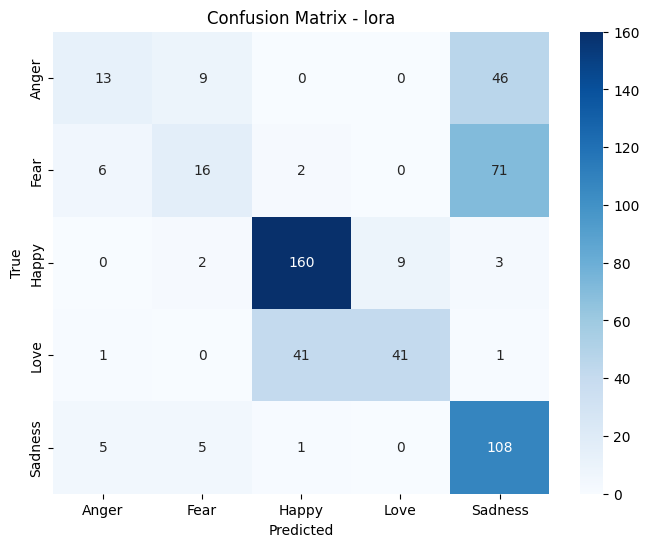

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: lora | Seed: 7 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 298,757 || Total params: 110,860,810 || Trainable %: 0.2695


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.091313,0.574074,0.378331
2,No log,0.878736,0.603704,0.448200
3,No log,0.826560,0.637037,0.517127
4,1.051300,0.817095,0.644444,0.528518


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 


--- Test Set Evaluation ---



Classification Report:
              precision    recall  f1-score   support

       Anger       0.65      0.19      0.30        68
        Fear       0.60      0.26      0.36        95
       Happy       0.76      0.94      0.84       174
        Love       0.87      0.40      0.55        84
     Sadness       0.47      0.88      0.61       119

    accuracy                           0.63       540
   macro avg       0.67      0.54      0.53       540
weighted avg       0.67      0.63      0.59       540



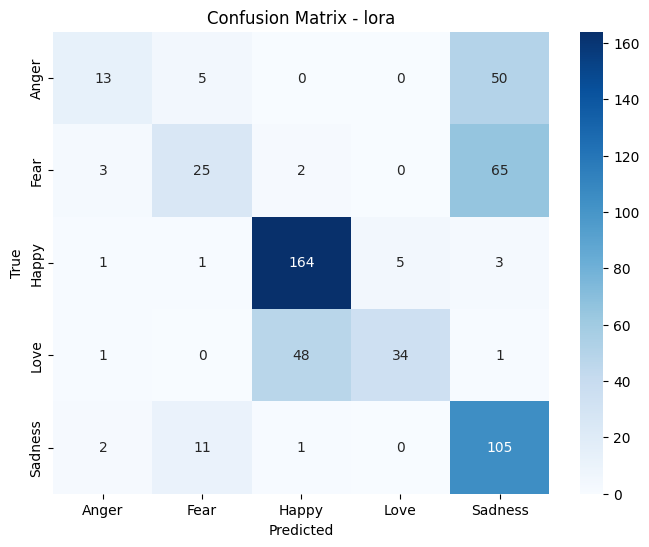

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: lora | Seed: 42 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 298,757 || Total params: 110,860,810 || Trainable %: 0.2695


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.180514,0.510204,0.297205
2,No log,0.889267,0.560297,0.363919
3,No log,0.846203,0.591837,0.449617
4,1.073800,0.836320,0.597403,0.463029


Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-lora-42/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-lora-42/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_downloa


--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.64      0.12      0.20        60
        Fear       0.57      0.19      0.29        84
       Happy       0.71      0.93      0.81       174
        Love       0.74      0.30      0.42        84
     Sadness       0.52      0.91      0.66       138

    accuracy                           0.62       540
   macro avg       0.64      0.49      0.48       540
weighted avg       0.64      0.62      0.56       540



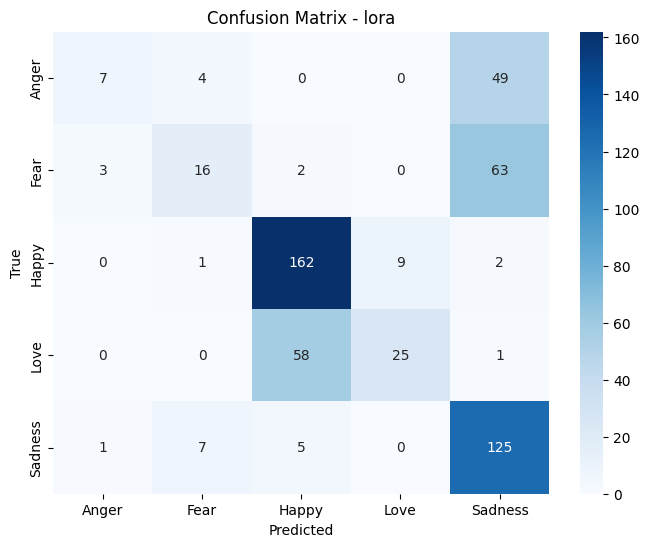

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: lora | Seed: 2023 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 298,757 || Total params: 110,860,810 || Trainable %: 0.2695


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.132833,0.491651,0.289336
2,No log,0.875986,0.558442,0.374486
3,No log,0.829864,0.610390,0.507158
4,1.042900,0.819000,0.608534,0.511762


Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-lora-2023/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-lora-2023/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_dow


--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.62      0.25      0.36        60
        Fear       0.50      0.14      0.22        84
       Happy       0.75      0.91      0.82       174
        Love       0.74      0.40      0.52        84
     Sadness       0.52      0.87      0.65       138

    accuracy                           0.63       540
   macro avg       0.63      0.52      0.51       540
weighted avg       0.63      0.63      0.59       540



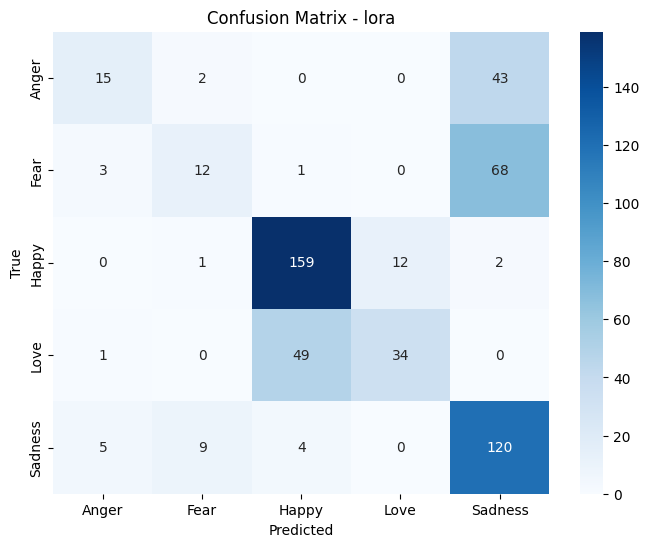

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: lora | Seed: 7 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Trainable params: 298,757 || Total params: 110,860,810 || Trainable %: 0.2695


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.110707,0.538033,0.358793
2,No log,0.886819,0.575139,0.418637
3,No log,0.842566,0.623377,0.523513
4,1.049100,0.833421,0.623377,0.525040


Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-lora-7/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-lora-7/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download`


--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.60      0.25      0.35        60
        Fear       0.53      0.20      0.29        84
       Happy       0.72      0.93      0.81       174
        Love       0.71      0.29      0.41        84
     Sadness       0.54      0.87      0.66       138

    accuracy                           0.62       540
   macro avg       0.62      0.51      0.50       540
weighted avg       0.63      0.62      0.58       540



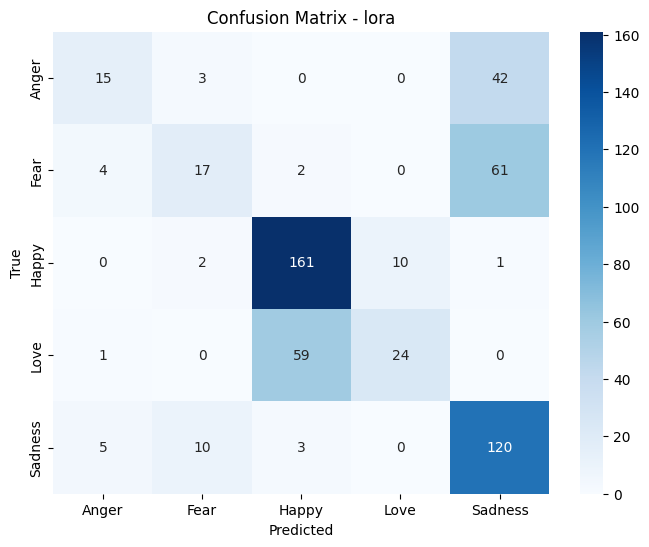

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [25]:
for dataset_name in CONFIG.DATASETS:
    for seed in CONFIG.SEEDS:
        try:
            train_df, val_df, test_df, id2label, label2id, text_col = load_presplit_data(  
                dataset_name, CONFIG.TARGET_COLUMN 
            )
            hf_datasets = convert_to_hf_dataset(train_df, val_df, test_df)
            
            results = train_and_evaluate_transformer(
                hf_datasets, text_col, MODEL_NAME, PEFT_METHOD, id2label, label2id, seed
            )
            
            run_info = {"dataset": dataset_name, "model": "IndoBERTweet LoRA", "seed": seed}
            run_info.update(results)
            all_results_C.append(run_info)
        except Exception as e:
            print(f"!!! GAGAL: Dataset {dataset_name}, Seed {seed}. Error: {e}")
            continue

In [26]:
if all_results_C:
    results_df_C = pd.DataFrame(all_results_C)
    print("Final Result for INDOBERTWEET + LORA")
    display(results_df_C)

Final Result for INDOBERTWEET + LORA


,dataset,model,seed,accuracy,f1-macro,precision-macro,recall-macro,total_train_time,peak_gpu_memory_mb,num_trainable_params,adapter_size_mb
0,raw,IndoBERTweet LoRA,42,0.614815,0.491225,0.704273,0.511672,132.127420,1317.46875,298757,1.151686
1,raw,IndoBERTweet LoRA,2023,0.625926,0.522146,0.619186,0.534959,132.010721,1317.46875,298757,1.151686
2,raw,IndoBERTweet LoRA,7,0.631481,0.533739,0.669715,0.536796,132.016366,1317.46875,298757,1.151686
3,norm,IndoBERTweet LoRA,42,0.620370,0.475196,0.635515,0.488319,131.894054,1317.46875,298757,1.151686
4,norm,IndoBERTweet LoRA,2023,0.629630,0.514210,0.625126,0.516195,131.726032,1317.46875,298757,1.151686
5,norm,IndoBERTweet LoRA,7,0.624074,0.504565,0.617680,0.506590,131.882886,1317.46875,298757,1.151686


# D. INDOBERT + LORA

In [27]:
all_results_D = []
MODEL_NAME = "indobenchmark/indobert-base-p1"
PEFT_METHOD = "lora"


Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indobenchmark/indobert-base-p1 | Method: lora | Seed: 42 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` ins

Trainable params: 298,757 || Total params: 124,743,946 || Trainable %: 0.2395


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.958273,0.538889,0.333047
2,No log,0.873775,0.598148,0.440275
3,No log,0.830486,0.618519,0.472788
4,1.021900,0.821356,0.614815,0.479169


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 


--- Test Set Evaluation ---



Classification Report:
              precision    recall  f1-score   support

       Anger       0.59      0.15      0.24        68
        Fear       0.55      0.31      0.39        95
       Happy       0.72      0.95      0.82       174
        Love       0.86      0.30      0.44        84
     Sadness       0.47      0.83      0.60       119

    accuracy                           0.61       540
   macro avg       0.64      0.51      0.50       540
weighted avg       0.64      0.61      0.56       540



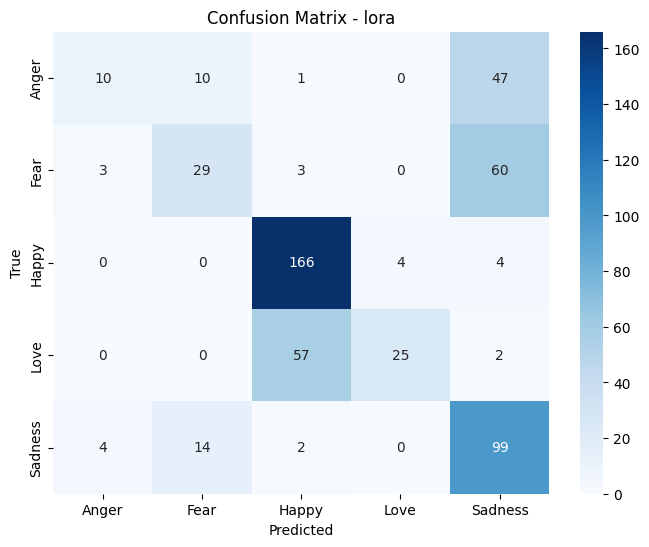

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indobenchmark/indobert-base-p1 | Method: lora | Seed: 2023 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` ins

Trainable params: 298,757 || Total params: 124,743,946 || Trainable %: 0.2395


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.949989,0.537037,0.336534
2,No log,0.892515,0.564815,0.372772
3,No log,0.853037,0.596296,0.416360
4,1.013700,0.845255,0.607407,0.441796


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 


--- Test Set Evaluation ---



Classification Report:
              precision    recall  f1-score   support

       Anger       0.70      0.10      0.18        68
        Fear       0.50      0.28      0.36        95
       Happy       0.70      0.95      0.81       174
        Love       0.82      0.17      0.28        84
     Sadness       0.47      0.88      0.61       119

    accuracy                           0.59       540
   macro avg       0.64      0.48      0.45       540
weighted avg       0.63      0.59      0.53       540



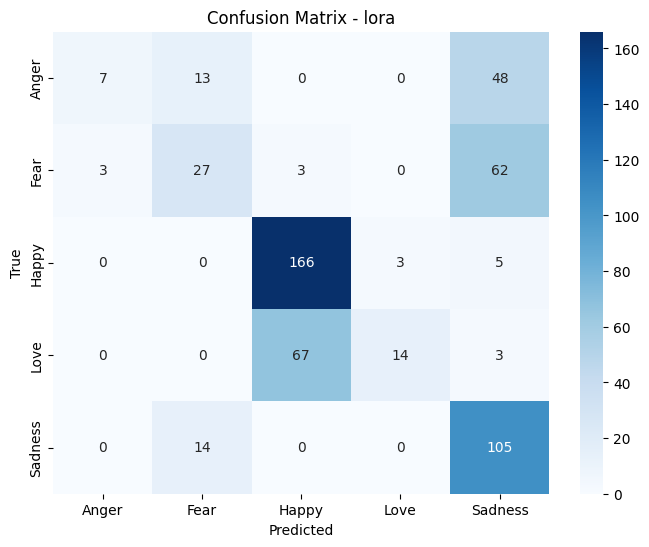

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indobenchmark/indobert-base-p1 | Method: lora | Seed: 7 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` ins

Trainable params: 298,757 || Total params: 124,743,946 || Trainable %: 0.2395


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.944319,0.529630,0.336036
2,No log,0.880117,0.579630,0.399387
3,No log,0.844135,0.592593,0.439979
4,1.014700,0.835633,0.600000,0.455572


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 


--- Test Set Evaluation ---



Classification Report:
              precision    recall  f1-score   support

       Anger       0.64      0.10      0.18        68
        Fear       0.46      0.23      0.31        95
       Happy       0.72      0.93      0.81       174
        Love       0.71      0.29      0.41        84
     Sadness       0.45      0.85      0.59       119

    accuracy                           0.58       540
   macro avg       0.59      0.48      0.46       540
weighted avg       0.60      0.58      0.53       540



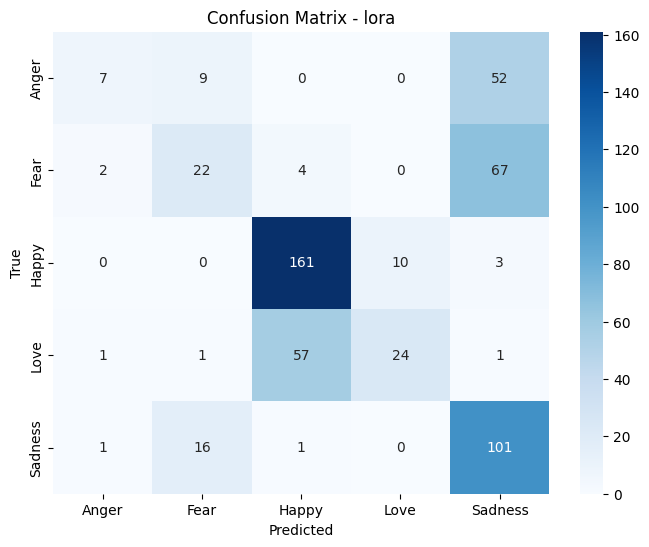

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indobenchmark/indobert-base-p1 | Method: lora | Seed: 42 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` ins

Trainable params: 298,757 || Total params: 124,743,946 || Trainable %: 0.2395


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.997135,0.526902,0.343290
2,No log,0.898650,0.547310,0.332197
3,No log,0.854881,0.606679,0.486092
4,1.024800,0.844653,0.614100,0.507228


Checkpoint destination directory /kaggle/working/models/indobert-base-p1-lora-42/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobert-base-p1-lora-42/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated a


--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       Anger       0.50      0.18      0.27        60
        Fear       0.55      0.19      0.28        84
       Happy       0.71      0.95      0.81       174
        Love       0.81      0.30      0.43        84
     Sadness       0.54      0.87      0.66       138

    accuracy                           0.63       540
   macro avg       0.62      0.50      0.49       540
weighted avg       0.63      0.63      0.57       540



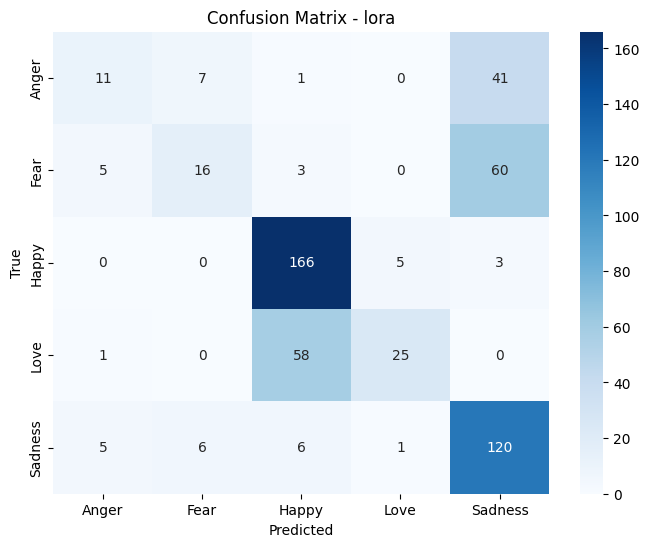

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indobenchmark/indobert-base-p1 | Method: lora | Seed: 2023 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` ins

Trainable params: 298,757 || Total params: 124,743,946 || Trainable %: 0.2395


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.977052,0.538033,0.359035
2,No log,0.920528,0.534323,0.297753
3,No log,0.880290,0.575139,0.412630
4,1.019300,0.872108,0.567718,0.407756


Checkpoint destination directory /kaggle/working/models/indobert-base-p1-lora-2023/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobert-base-p1-lora-2023/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecat


--- Test Set Evaluation ---



Classification Report:
              precision    recall  f1-score   support

       Anger       0.67      0.07      0.12        60
        Fear       0.44      0.20      0.28        84
       Happy       0.67      0.98      0.79       174
        Love       0.88      0.08      0.15        84
     Sadness       0.51      0.86      0.64       138

    accuracy                           0.59       540
   macro avg       0.63      0.44      0.40       540
weighted avg       0.62      0.59      0.50       540



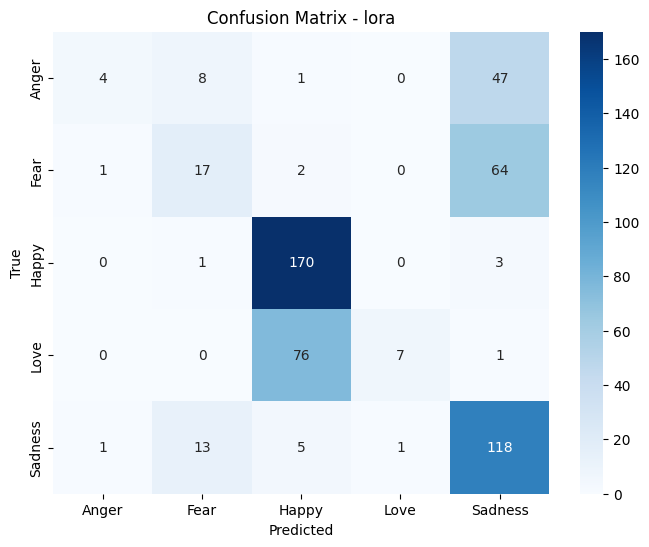

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indobenchmark/indobert-base-p1 | Method: lora | Seed: 7 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` ins

Trainable params: 298,757 || Total params: 124,743,946 || Trainable %: 0.2395


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,0.962740,0.521336,0.343590
2,No log,0.900740,0.545455,0.332057
3,No log,0.868947,0.586271,0.441604
4,1.009600,0.861585,0.595547,0.476218


Checkpoint destination directory /kaggle/working/models/indobert-base-p1-lora-7/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobert-base-p1-lora-7/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and


--- Test Set Evaluation ---



Classification Report:
              precision    recall  f1-score   support

       Anger       0.58      0.12      0.19        60
        Fear       0.53      0.19      0.28        84
       Happy       0.70      0.96      0.81       174
        Love       0.76      0.23      0.35        84
     Sadness       0.51      0.86      0.64       138

    accuracy                           0.61       540
   macro avg       0.62      0.47      0.45       540
weighted avg       0.62      0.61      0.54       540



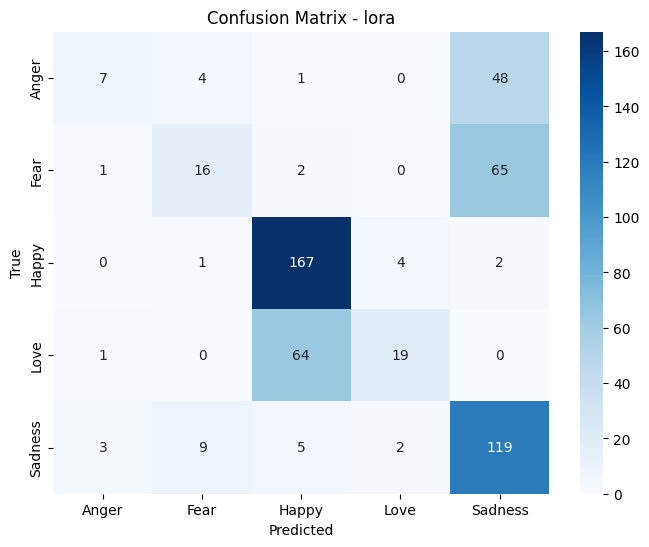

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [28]:
for dataset_name in CONFIG.DATASETS:  
    for seed in CONFIG.SEEDS:
        try:
            train_df, val_df, test_df, id2label, label2id, text_col = load_presplit_data(  
                dataset_name, CONFIG.TARGET_COLUMN 
            )
            hf_datasets = convert_to_hf_dataset(train_df, val_df, test_df)
            
            results = train_and_evaluate_transformer(
                hf_datasets, text_col, MODEL_NAME, PEFT_METHOD, id2label, label2id, seed
            )
            
            run_info = {"dataset": dataset_name, "model": "IndoBERT LoRA", "seed": seed}
            run_info.update(results)
            all_results_D.append(run_info)
        except Exception as e:
            print(f"!!! GAGAL: Dataset {dataset_name}, Seed {seed}. Error: {e}")
            continue

In [29]:
if all_results_D:
    results_df_D = pd.DataFrame(all_results_D)
    print("Final Result for INDOBERT + LORA")
    display(results_df_D)

Final Result for INDOBERT + LORA


,dataset,model,seed,accuracy,f1-macro,precision-macro,recall-macro,total_train_time,peak_gpu_memory_mb,num_trainable_params,adapter_size_mb
0,raw,IndoBERT LoRA,42,0.609259,0.498335,0.637869,0.507179,137.803270,1473.964844,298757,1.15168
1,raw,IndoBERT LoRA,2023,0.590741,0.448584,0.639554,0.478039,137.702303,1473.964844,298757,1.15168
2,raw,IndoBERT LoRA,7,0.583333,0.458338,0.594689,0.478852,137.703606,1473.964844,298757,1.15168
3,norm,IndoBERT LoRA,42,0.625926,0.492594,0.620658,0.499003,137.555664,1473.964844,298757,1.15168
4,norm,IndoBERT LoRA,2023,0.585185,0.396064,0.630659,0.436893,137.520069,1473.964844,298757,1.15168
5,norm,IndoBERT LoRA,7,0.607407,0.454454,0.616792,0.471084,137.322575,1473.964844,298757,1.15168


# E. INDOBERTWEET + QLORA

In [30]:
all_results_E = []
MODEL_NAME = "indolem/indobertweet-base-uncased"
PEFT_METHOD = "qlora"

In [31]:
for dataset_name in CONFIG.DATASETS:  # ← CHANGED HERE
    for seed in CONFIG.SEEDS:
        try:
            train_df, val_df, test_df, id2label, label2id, text_col = load_presplit_data(  # ← CHANGED HERE (6 values)
                dataset_name, CONFIG.TARGET_COLUMN  # ← CHANGED HERE (2 args only)
            )
            hf_datasets = convert_to_hf_dataset(train_df, val_df, test_df)
            
            results = train_and_evaluate_transformer(
                hf_datasets, text_col, MODEL_NAME, PEFT_METHOD, id2label, label2id, seed
            )
            
            run_info = {"dataset": dataset_name, "model": "IndoBERTweet QLoRA", "seed": seed}
            run_info.update(results)
            all_results_E.append(run_info)
        except Exception as e:
            print(f"!!! GAGAL: Dataset {dataset_name}, Seed {seed}. Error: {e}")
            continue


Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: qlora | Seed: 42 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

!!! GAGAL: Dataset raw, Seed 42. Error: No package metadata was found for bitsandbytes

Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: qlora | Seed: 2023 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

!!! GAGAL: Dataset raw, Seed 2023. Error: No package metadata was found for bitsandbytes

Data: raw
Train: 4320, Val: 540, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: qlora | Seed: 7 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

!!! GAGAL: Dataset raw, Seed 7. Error: No package metadata was found for bitsandbytes

Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: qlora | Seed: 42 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

!!! GAGAL: Dataset norm, Seed 42. Error: No package metadata was found for bitsandbytes

Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: qlora | Seed: 2023 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

!!! GAGAL: Dataset norm, Seed 2023. Error: No package metadata was found for bitsandbytes

Data: norm
Train: 4314, Val: 539, Test: 540

----- Training: indolem/indobertweet-base-uncased | Method: qlora | Seed: 7 -----


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

!!! GAGAL: Dataset norm, Seed 7. Error: No package metadata was found for bitsandbytes


In [32]:
if all_results_E:
    results_df_E = pd.DataFrame(all_results_E)
    print("Final Result for INDOBERTWEET + QLORA")
    display(results_df_E)

# F. INDOBERTWEET + Prefix Tuning

In [33]:
from peft import PrefixTuningConfig

all_results_F = []
MODEL_NAME = "indolem/indobertweet-base-uncased"
PEFT_METHOD = "prefix_tuning"

In [34]:
for dataset_name in CONFIG.DATASETS:
    for seed in CONFIG.SEEDS:
        try:
            train_df, val_df, test_df, id2label, label2id, text_col = load_presplit_data(
                dataset_name, CONFIG.TARGET_COLUMN
            )
            hf_datasets = convert_to_hf_dataset(train_df, val_df, test_df)
            
            # Modify training function to support prefix tuning
            set_seed(seed)
            tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
            if tokenizer.pad_token is None: 
                tokenizer.pad_token = tokenizer.eos_token
            
            def tokenize_function(examples):
                return tokenizer(examples[text_col], padding="max_length", truncation=True, max_length=CONFIG.MAX_LENGTH)
            tokenized_datasets = hf_datasets.map(tokenize_function, batched=True)
            
            # Load base model
            model = AutoModelForSequenceClassification.from_pretrained(
                MODEL_NAME, num_labels=len(id2label), id2label=id2label, label2id=label2id
            )
            model.to("cuda")
            model.config.pad_token_id = tokenizer.pad_token_id
            
            # Apply Prefix Tuning
            prefix_config = PrefixTuningConfig(
                task_type=TaskType.SEQ_CLS,
                num_virtual_tokens=20,
                prefix_projection=False
            )
            model = get_peft_model(model, prefix_config)
            model.print_trainable_parameters()
            
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            
            # Training
            output_path = os.path.join(CONFIG.OUTPUT_DIR, f"{MODEL_NAME.split('/')[-1]}-prefix-{seed}")
            
            def compute_metrics_trainer(eval_pred):
                logits, labels = eval_pred
                predictions = np.argmax(logits, axis=-1)
                return {"accuracy": accuracy_score(labels, predictions), "f1-macro": f1_score(labels, predictions, average="macro")}
            
            training_args = TrainingArguments(
                output_dir=output_path, num_train_epochs=CONFIG.EPOCHS,
                per_device_train_batch_size=CONFIG.BATCH_SIZE, per_device_eval_batch_size=CONFIG.BATCH_SIZE,
                learning_rate=1e-4, weight_decay=0.01, evaluation_strategy="epoch", save_strategy="epoch",
                load_best_model_at_end=True, metric_for_best_model="f1-macro", greater_is_better=True,
                fp16=True, report_to="none"
            )
            trainer = Trainer(
                model=model, args=training_args, train_dataset=tokenized_datasets["train"],
                eval_dataset=tokenized_datasets["validation"], tokenizer=tokenizer, 
                compute_metrics=compute_metrics_trainer,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )
            
            torch.cuda.reset_peak_memory_stats()
            start_time = time.time()
            trainer.train()
            total_train_time = time.time() - start_time
            peak_gpu_memory_mb = torch.cuda.max_memory_allocated() / (1024**2)
            
            # Evaluate
            test_predictions = trainer.predict(tokenized_datasets["test"])
            y_true = test_predictions.label_ids
            y_pred = np.argmax(test_predictions.predictions, axis=-1)
            
            print("\nClassification Report")
            class_names = list(label2id.keys())
            print(classification_report(y_true, y_pred, target_names=class_names))
            
            # Save adapter
            adapter_path = os.path.join(output_path, "final_adapter")
            model.save_pretrained(adapter_path)
            adapter_size_mb = sum(os.path.getsize(os.path.join(adapter_path, f)) for f in os.listdir(adapter_path)) / (1024**2)
            
            results = {
                "accuracy": accuracy_score(y_true, y_pred),
                "f1-macro": f1_score(y_true, y_pred, average="macro"),
                "precision-macro": precision_score(y_true, y_pred, average="macro"),
                "recall-macro": recall_score(y_true, y_pred, average="macro"),
                "total_train_time": total_train_time,
                "peak_gpu_memory_mb": peak_gpu_memory_mb,
                "num_trainable_params": trainable_params,
                "adapter_size_mb": adapter_size_mb
            }
            
            run_info = {"dataset": dataset_name, "model": "IndoBERTweet Prefix", "seed": seed}
            run_info.update(results)
            all_results_F.append(run_info)
            
            del model, trainer
            gc.collect()
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"!!! GAGAL: Dataset {dataset_name}, Seed {seed}. Error: {e}")
            continue


Data: raw
Train: 4320, Val: 540, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

trainable params: 372,485 || all params: 110,934,538 || trainable%: 0.3357700917274294


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.492932,0.346296,0.122789
2,No log,1.466415,0.364815,0.155939
3,No log,1.451737,0.370370,0.164728
4,1.531500,1.447194,0.370370,0.169183


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 


Classification Report
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        68
        Fear       0.19      0.03      0.05        95
       Happy       0.35      0.98      0.52       174
        Love       0.00      0.00      0.00        84
     Sadness       0.27      0.08      0.13       119

    accuracy                           0.34       540
   macro avg       0.16      0.22      0.14       540
weighted avg       0.21      0.34      0.20       540



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_dow


Data: raw
Train: 4320, Val: 540, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

trainable params: 372,485 || all params: 110,934,538 || trainable%: 0.3357700917274294


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.498213,0.346296,0.113869
2,No log,1.470133,0.361111,0.135552
3,No log,1.452478,0.370370,0.147114
4,1.519600,1.447094,0.372222,0.149465


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 


Classification Report
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        68
        Fear       0.00      0.00      0.00        95
       Happy       0.35      0.99      0.51       174
        Love       0.00      0.00      0.00        84
     Sadness       0.43      0.16      0.23       119

    accuracy                           0.35       540
   macro avg       0.16      0.23      0.15       540
weighted avg       0.21      0.35      0.22       540



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_dow


Data: raw
Train: 4320, Val: 540, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

trainable params: 372,485 || all params: 110,934,538 || trainable%: 0.3357700917274294


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.487711,0.372222,0.161399
2,No log,1.461196,0.396296,0.198625
3,No log,1.445204,0.401852,0.205329
4,1.522300,1.440666,0.405556,0.208707


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 


Classification Report
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        68
        Fear       0.47      0.09      0.16        95
       Happy       0.39      0.98      0.56       174
        Love       0.00      0.00      0.00        84
     Sadness       0.45      0.33      0.38       119

    accuracy                           0.41       540
   macro avg       0.26      0.28      0.22       540
weighted avg       0.31      0.41      0.29       540



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_dow


Data: norm
Train: 4314, Val: 539, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

trainable params: 372,485 || all params: 110,934,538 || trainable%: 0.3357700917274294


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.515764,0.330241,0.115173
2,No log,1.493896,0.341373,0.135784
3,No log,1.477877,0.346939,0.151173
4,1.526800,1.472837,0.356215,0.166904


Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-prefix-42/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-prefix-42/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_dow


Classification Report
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        60
        Fear       0.40      0.05      0.09        84
       Happy       0.34      0.98      0.51       174
        Love       0.00      0.00      0.00        84
     Sadness       0.44      0.11      0.17       138

    accuracy                           0.35       540
   macro avg       0.24      0.23      0.15       540
weighted avg       0.29      0.35      0.22       540



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_dow


Data: norm
Train: 4314, Val: 539, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

trainable params: 372,485 || all params: 110,934,538 || trainable%: 0.3357700917274294


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.509758,0.324675,0.101644
2,No log,1.484080,0.345083,0.136396
3,No log,1.466041,0.354360,0.149364
4,1.519600,1.460514,0.356215,0.153605


Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-prefix-2023/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-prefix-2023/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume


Classification Report
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        60
        Fear       0.33      0.01      0.02        84
       Happy       0.35      0.99      0.52       174
        Love       0.00      0.00      0.00        84
     Sadness       0.58      0.19      0.28       138

    accuracy                           0.37       540
   macro avg       0.25      0.24      0.16       540
weighted avg       0.31      0.37      0.24       540



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_dow


Data: norm
Train: 4314, Val: 539, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

trainable params: 372,485 || all params: 110,934,538 || trainable%: 0.3357700917274294


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,1.513418,0.352505,0.160597
2,No log,1.489874,0.382189,0.191197
3,No log,1.473248,0.389610,0.204500
4,1.519100,1.467962,0.389610,0.209285


Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-prefix-7/checkpoint-135 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Checkpoint destination directory /kaggle/working/models/indobertweet-base-uncased-prefix-7/checkpoint-270 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_downl


Classification Report
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        60
        Fear       0.33      0.05      0.08        84
       Happy       0.38      0.95      0.54       174
        Love       0.00      0.00      0.00        84
     Sadness       0.43      0.28      0.33       138

    accuracy                           0.38       540
   macro avg       0.23      0.25      0.19       540
weighted avg       0.28      0.38      0.27       540



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_dow

In [35]:
if all_results_F:
    results_df_F = pd.DataFrame(all_results_F)
    print("Final Result for INDOBERTWEET + Prefix Tuning")
    display(results_df_F)

Final Result for INDOBERTWEET + Prefix Tuning


,dataset,model,seed,accuracy,f1-macro,precision-macro,recall-macro,total_train_time,peak_gpu_memory_mb,num_trainable_params,adapter_size_mb
0,raw,IndoBERTweet Prefix,42,0.340741,0.139931,0.161780,0.219674,128.894613,1317.833008,372485,1.426439
1,raw,IndoBERTweet Prefix,2023,0.353704,0.149620,0.155999,0.229634,128.750130,1317.833008,372485,1.426439
2,raw,IndoBERTweet Prefix,7,0.405556,0.219992,0.264055,0.281045,128.769013,1317.833008,372485,1.426439
3,norm,IndoBERTweet Prefix,42,0.351852,0.153995,0.237187,0.227815,128.570683,1317.833008,372485,1.426439
4,norm,IndoBERTweet Prefix,2023,0.368519,0.164732,0.252141,0.237763,128.532871,1317.833008,372485,1.426439
5,norm,IndoBERTweet Prefix,7,0.383333,0.191470,0.227402,0.254251,128.464401,1317.833008,372485,1.426439


# Results

In [36]:
if 'all_results_A' not in locals(): all_results_A = []  # TF-IDF
if 'all_results_B' not in locals(): all_results_B = []  # Full FT
if 'all_results_C' not in locals(): all_results_C = []  # IndoBERTweet LoRA
if 'all_results_D' not in locals(): all_results_D = []  # IndoBERT LoRA
if 'all_results_E' not in locals(): all_results_E = []  # IndoBERTweet QLoRA
if 'all_results_F' not in locals(): all_results_F = []  # IndoBERTweet Full FT

all_results_combined = all_results_A + all_results_B + all_results_C + all_results_D + all_results_E + all_results_F

if all_results_combined:
    results_df = pd.DataFrame(all_results_combined)
    
    # Mean & Standard Deviation
    summary_df = results_df.groupby(['dataset', 'model']).agg(
        f1_macro_mean=('f1-macro', 'mean'),
        f1_macro_std=('f1-macro', 'std'),
        accuracy_mean=('accuracy', 'mean'),
        accuracy_std=('accuracy', 'std'),
        train_time_mean=('total_train_time', 'mean'),
        gpu_mem_mean=('peak_gpu_memory_mb', 'mean'),
        trainable_params=('num_trainable_params', 'first'),
        adapter_size_mean=('adapter_size_mb', 'mean')
    ).reset_index()
    
    def format_with_std(mean, std):
        std_val = std if pd.notna(std) else 0
        return f"{mean:.4f} ± {std_val:.4f}"
    
    summary_df['F1-Macro'] = summary_df.apply(lambda r: format_with_std(r['f1_macro_mean'], r['f1_macro_std']), axis=1)
    summary_df['Accuracy'] = summary_df.apply(lambda r: format_with_std(r['accuracy_mean'], r['accuracy_std']), axis=1)
    
    # Sort BEFORE renaming columns
    summary_df = summary_df.sort_values(by=['dataset', 'f1_macro_mean'], ascending=[True, False])
    
    # Now create final report with renamed columns
    final_report = summary_df[[
        'dataset', 'model', 'F1-Macro', 'Accuracy',
        'train_time_mean', 'gpu_mem_mean', 'trainable_params', 'adapter_size_mean'
    ]].copy()
    
    final_report.columns = ['Dataset', 'Model', 'F1-Macro', 'Accuracy', 'Avg Time (s)', 'Avg Peak GPU (MB)', '# Trainable Params', 'Adapter Size (MB)']
    
    print("\n\nResults Table")
    display(final_report)
    
    final_report.to_csv('/kaggle/working/final_results_summary.csv', index=False)
    
else:
    print("\nError.")



Results Table


,Dataset,Model,F1-Macro,Accuracy,Avg Time (s),Avg Peak GPU (MB),# Trainable Params,Adapter Size (MB)
1,norm,IndoBERTweet Full FT,0.6706 ± 0.0133,0.7080 ± 0.0126,184.006651,2178.003906,110562053,0.000000
4,norm,TF-IDF + LogReg,0.5668 ± 0.0000,0.6333 ± 0.0000,0.143406,0.000000,42090,0.000000
2,norm,IndoBERTweet LoRA,0.4980 ± 0.0203,0.6247 ± 0.0047,131.834324,1317.468750,298757,1.151686
0,norm,IndoBERT LoRA,0.4477 ± 0.0486,0.6062 ± 0.0204,137.466103,1473.964844,298757,1.151680
3,norm,IndoBERTweet Prefix,0.1701 ± 0.0193,0.3679 ± 0.0157,128.522652,1317.833008,372485,1.426439
6,raw,IndoBERTweet Full FT,0.6715 ± 0.0097,0.7037 ± 0.0085,180.330068,2176.821615,110562053,0.000000
9,raw,TF-IDF + LogReg,0.5754 ± 0.0000,0.6352 ± 0.0000,0.151144,0.000000,42065,0.000000
7,raw,IndoBERTweet LoRA,0.5157 ± 0.0220,0.6241 ± 0.0085,132.051502,1317.468750,298757,1.151686
5,raw,IndoBERT LoRA,0.4684 ± 0.0264,0.5944 ± 0.0134,137.736393,1473.964844,298757,1.151680
8,raw,IndoBERTweet Prefix,0.1698 ± 0.0437,0.3667 ± 0.0343,128.804585,1317.833008,372485,1.426439


In [37]:
if all_results_combined:
    results_df = pd.DataFrame(all_results_combined)
    print(results_df.groupby(['dataset', 'model'])['seed'].count())
    display(results_df)

dataset  model               
norm     IndoBERT LoRA           3
         IndoBERTweet Full FT    3
         IndoBERTweet LoRA       3
         IndoBERTweet Prefix     3
         TF-IDF + LogReg         3
raw      IndoBERT LoRA           3
         IndoBERTweet Full FT    3
         IndoBERTweet LoRA       3
         IndoBERTweet Prefix     3
         TF-IDF + LogReg         3
Name: seed, dtype: int64


,dataset,model,seed,accuracy,f1-macro,precision-macro,recall-macro,total_train_time,peak_gpu_memory_mb,num_trainable_params,adapter_size_mb
0,raw,TF-IDF + LogReg,42,0.635185,0.575449,0.620004,0.566531,0.162115,0.000000,42065,0.000000
1,raw,TF-IDF + LogReg,2023,0.635185,0.575449,0.620004,0.566531,0.146538,0.000000,42065,0.000000
2,raw,TF-IDF + LogReg,7,0.635185,0.575449,0.620004,0.566531,0.144779,0.000000,42065,0.000000
3,norm,TF-IDF + LogReg,42,0.633333,0.566769,0.607896,0.555480,0.146075,0.000000,42090,0.000000
4,norm,TF-IDF + LogReg,2023,0.633333,0.566769,0.607896,0.555480,0.145076,0.000000,42090,0.000000
5,norm,TF-IDF + LogReg,7,0.633333,0.566769,0.607896,0.555480,0.139065,0.000000,42090,0.000000
6,raw,IndoBERTweet Full FT,42,0.696296,0.662203,0.667922,0.658465,174.777088,2173.246094,110562053,0.000000
7,raw,IndoBERTweet Full FT,2023,0.712963,0.681486,0.683823,0.681067,182.538060,2178.984375,110562053,0.000000
8,raw,IndoBERTweet Full FT,7,0.701852,0.670751,0.673092,0.668993,183.675057,2178.234375,110562053,0.000000
9,norm,IndoBERTweet Full FT,42,0.698148,0.660799,0.666908,0.656088,184.519881,2178.234375,110562053,0.000000


# Statistical Significance Testing

In [38]:
from scipy.stats import wilcoxon

In [39]:
def paired_wilcoxon_test(baseline_scores, model_scores):
    """Perform Wilcoxon signed-rank test"""
    if len(baseline_scores) < 2 or len(model_scores) < 2:
        return None, None, None
    
    statistic, p_value = wilcoxon(baseline_scores, model_scores)
    
    # Effect size (r = Z / sqrt(N))
    from scipy import stats
    n = len(baseline_scores)
    z_score = stats.norm.ppf(1 - p_value/2)
    effect_size = abs(z_score) / np.sqrt(n)
    
    return statistic, p_value, effect_size

In [40]:
print("Statistical Significance Tests (vs TF-IDF Baseline)")

for dataset in results_df['dataset'].unique():
    print(f"\n Dataset: {dataset}")
    
    # Get baseline (TF-IDF) scores
    baseline_scores = results_df[
        (results_df['dataset'] == dataset) & 
        (results_df['model'] == 'TF-IDF + LogReg')
    ]['f1-macro'].values
    
    if len(baseline_scores) == 0:
        continue
    
    baseline_mean = np.mean(baseline_scores)
    print(f"   Baseline F1: {baseline_mean:.4f}")
    
    # Compare each other model
    for model in results_df['model'].unique():
        if model == 'TF-IDF + LogReg':
            continue
        
        model_scores = results_df[
            (results_df['dataset'] == dataset) & 
            (results_df['model'] == model)
        ]['f1-macro'].values
        
        if len(model_scores) == 0:
            continue
        
        model_mean = np.mean(model_scores)
        improvement = ((model_mean - baseline_mean) / baseline_mean) * 100
        
        stat, p_val, effect = paired_wilcoxon_test(baseline_scores, model_scores)
        
        if p_val is not None:
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            effect_interp = "large" if effect >= 0.5 else "medium" if effect >= 0.3 else "small"
            
            print(f"   {model:30s}: F1={model_mean:.4f} | Δ={improvement:+.2f}% | p={p_val:.4f} {sig} | r={effect:.3f} ({effect_interp})")

# Notes
# Significance: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant
# Effect size: small (<0.3), medium (0.3-0.5), large (≥0.5)

Statistical Significance Tests (vs TF-IDF Baseline)

 Dataset: raw
   Baseline F1: 0.5754
   IndoBERTweet Full FT          : F1=0.6715 | Δ=+16.69% | p=0.2500 ns | r=0.664 (large)
   IndoBERTweet LoRA             : F1=0.5157 | Δ=-10.38% | p=0.2500 ns | r=0.664 (large)
   IndoBERT LoRA                 : F1=0.4684 | Δ=-18.60% | p=0.2500 ns | r=0.664 (large)
   IndoBERTweet Prefix           : F1=0.1698 | Δ=-70.48% | p=0.2500 ns | r=0.664 (large)

 Dataset: norm
   Baseline F1: 0.5668
   IndoBERTweet Full FT          : F1=0.6706 | Δ=+18.31% | p=0.2500 ns | r=0.664 (large)
   IndoBERTweet LoRA             : F1=0.4980 | Δ=-12.14% | p=0.2500 ns | r=0.664 (large)
   IndoBERT LoRA                 : F1=0.4477 | Δ=-21.01% | p=0.2500 ns | r=0.664 (large)
   IndoBERTweet Prefix           : F1=0.1701 | Δ=-69.99% | p=0.2500 ns | r=0.664 (large)


# Cross Domain Evaluation (ΔF1 Analysis) on The Best Model

In [41]:
cross_domain_results = []

domain_pairs = [
    ('raw', 'norm'),  # Train on raw, test on norm
    ('norm', 'raw'),  # Train on norm, test on raw
]

models_to_test = [
    ("indolem/indobertweet-base-uncased", "lora", "IndoBERTweet LoRA"),
    ("indobenchmark/indobert-base-p1", "lora", "IndoBERT LoRA"),
]

In [42]:
for model_name, peft_method, model_label in models_to_test:
    for train_domain, test_domain in domain_pairs:
        print(f"\nTrain on {train_domain} → Test on {test_domain} | Model: {model_label}")
        
        try:
            # Load TRAINING domain
            train_df, val_df, _, id2label, label2id, text_col_train = load_presplit_data(
                train_domain, CONFIG.TARGET_COLUMN
            )
            
            # Load IN-DOMAIN test (same as training)
            _, _, test_in_df, _, _, _ = load_presplit_data(
                train_domain, CONFIG.TARGET_COLUMN
            )
            
            # Load CROSS-DOMAIN test (different from training)
            _, _, test_cross_df, _, _, text_col_cross = load_presplit_data(
                test_domain, CONFIG.TARGET_COLUMN
            )
            
            # Train model (use seed 42 only for speed)
            hf_datasets = convert_to_hf_dataset(train_df, val_df, test_in_df)
            
            # Quick training function inline
            set_seed(42)
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token
            
            def tokenize_function(examples):
                return tokenizer(examples[text_col_train], padding="max_length", truncation=True, max_length=64)
            
            tokenized_train = hf_datasets.map(tokenize_function, batched=True)
            
            # Load and configure model
            model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=len(id2label), id2label=id2label, label2id=label2id
            )
            model.to("cuda")
            model.config.pad_token_id = tokenizer.pad_token_id
            
            lora_config = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.1, bias="none", task_type=TaskType.SEQ_CLS)
            model = get_peft_model(model, lora_config)
            
            training_args = TrainingArguments(
                output_dir=f"/tmp/{model_label}-{train_domain}",
                num_train_epochs=2,  # Reduced for speed
                per_device_train_batch_size=16,
                per_device_eval_batch_size=16,
                learning_rate=1e-4,
                fp16=True,
                report_to="none",
                evaluation_strategy="no"
            )
            
            trainer = Trainer(
                model=model, args=training_args,
                train_dataset=tokenized_train["train"],
                tokenizer=tokenizer
            )
            
            trainer.train()
            
            # Evaluate IN-DOMAIN
            preds_in = trainer.predict(tokenized_train["test"])
            y_true_in = preds_in.label_ids
            y_pred_in = np.argmax(preds_in.predictions, axis=-1)
            f1_in = f1_score(y_true_in, y_pred_in, average='macro')
            
            # Evaluate CROSS-DOMAIN
            # Tokenize cross-domain test with correct text column
            cross_dataset = Dataset.from_pandas(test_cross_df)
            
            def tokenize_cross(examples):
                return tokenizer(examples[text_col_cross], padding="max_length", truncation=True, max_length=64)
            
            tokenized_cross = cross_dataset.map(tokenize_cross, batched=True)
            
            preds_cross = trainer.predict(tokenized_cross)
            y_true_cross = preds_cross.label_ids
            y_pred_cross = np.argmax(preds_cross.predictions, axis=-1)
            f1_cross = f1_score(y_true_cross, y_pred_cross, average='macro')
            
            # Compute ΔF1
            delta_f1 = f1_in - f1_cross
            
            print(f"   In-domain F1:    {f1_in:.4f}")
            print(f"   Cross-domain F1: {f1_cross:.4f}")
            print(f"   ΔF1:             {delta_f1:.4f} ({delta_f1*100:+.2f}%)")
            
            cross_domain_results.append({
                'model': model_label,
                'train_domain': train_domain,
                'test_domain': test_domain,
                'f1_in_domain': f1_in,
                'f1_cross_domain': f1_cross,
                'delta_f1': delta_f1
            })
            
            del model, trainer
            gc.collect()
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Failed: {e}")
            continue


Train on raw → Test on norm | Model: IndoBERTweet LoRA

Data: raw
Train: 4320, Val: 540, Test: 540

Data: raw
Train: 4320, Val: 540, Test: 540

Data: norm
Train: 4314, Val: 539, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Step,Training Loss


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


   In-domain F1:    0.3300
   Cross-domain F1: 0.3223
   ΔF1:             0.0078 (+0.78%)

Train on norm → Test on raw | Model: IndoBERTweet LoRA

Data: norm
Train: 4314, Val: 539, Test: 540

Data: norm
Train: 4314, Val: 539, Test: 540

Data: raw
Train: 4320, Val: 540, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` 

Step,Training Loss


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


   In-domain F1:    0.3250
   Cross-domain F1: 0.3491
   ΔF1:             -0.0241 (-2.41%)

Train on raw → Test on norm | Model: IndoBERT LoRA

Data: raw
Train: 4320, Val: 540, Test: 540

Data: raw
Train: 4320, Val: 540, Test: 540

Data: norm
Train: 4314, Val: 539, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` ins

Step,Training Loss


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


   In-domain F1:    0.3208
   Cross-domain F1: 0.3327
   ΔF1:             -0.0119 (-1.19%)

Train on norm → Test on raw | Model: IndoBERT LoRA

Data: norm
Train: 4314, Val: 539, Test: 540

Data: norm
Train: 4314, Val: 539, Test: 540

Data: raw
Train: 4320, Val: 540, Test: 540


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4314 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` ins

Step,Training Loss


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


   In-domain F1:    0.3215
   Cross-domain F1: 0.3028
   ΔF1:             0.0187 (+1.87%)


In [43]:
# Summary table
if cross_domain_results:
    cross_df = pd.DataFrame(cross_domain_results)
    print("----- Cross Domain Results -----")
    display(cross_df)
    
    cross_df.to_csv('/kaggle/working/cross_domain_results.csv', index=False)

----- Cross Domain Results -----


,model,train_domain,test_domain,f1_in_domain,f1_cross_domain,delta_f1
0,IndoBERTweet LoRA,raw,norm,0.330037,0.322263,0.007774
1,IndoBERTweet LoRA,norm,raw,0.324980,0.349101,-0.024121
2,IndoBERT LoRA,raw,norm,0.320838,0.332698,-0.011860
3,IndoBERT LoRA,norm,raw,0.321474,0.302813,0.018661


# Save The Results

In [44]:
raw_path = "/kaggle/working/results_raw_runs.csv"
results_df.to_csv(raw_path, index=False)

In [45]:
summary_path = "/kaggle/working/results_summary_mean_std.csv"
final_report.to_csv(summary_path, index=False)

In [46]:
numeric_summary_path = "/kaggle/working/results_summary_numeric.csv"

summary_df[[
    'dataset',
    'model',
    'f1_macro_mean',
    'f1_macro_std',
    'accuracy_mean',
    'accuracy_std',
    'train_time_mean',
    'gpu_mem_mean',
    'trainable_params',
    'adapter_size_mean'
]].to_csv(numeric_summary_path, index=False)